In [1]:
import re
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json
from matplotlib import cm                   # To get certain color maps for plotting
from matplotlib.colors import to_hex
from datetime import datetime
from statsmodels.stats.weightstats import ttest_ind as sm_ttest
from scipy.stats import ttest_ind as sp_ttest
import scipy
import itertools
from nltk import wordpunct_tokenize, WordNetLemmatizer, pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc,  classification_report
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
#%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
pd.set_option('display.width', 500)
pd.set_option('max_columns', 60)

In [3]:
reviews=[]
with open('yelp/review.json', encoding='utf8') as file:
    for chunk in pd.read_json(file, lines=True, chunksize=1000):
        reviews.append(chunk)

In [4]:
all_reviews=pd.concat(reviews, ignore_index=True)

In [5]:
all_reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261669 entries, 0 to 5261668
Data columns (total 9 columns):
business_id    5261669 non-null object
cool           5261669 non-null int64
date           5261669 non-null datetime64[ns]
funny          5261669 non-null int64
review_id      5261669 non-null object
stars          5261669 non-null int64
text           5261669 non-null object
useful         5261669 non-null int64
user_id        5261669 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 361.3+ MB


In [6]:
all_reviews.to_csv('yelp_reviews.csv')

In [2]:
reviews=pd.read_csv('yelp_reviews.csv', low_memory=False, index_col=0)

In [3]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0.0,v0i_UHJMo_hPBq9bxWvW4w,5.0,"Love the staff, love the meat, love the place....",0.0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0.0,vkVSCC7xljjrAI4UGfnKEQ,5.0,Super simple place but amazing nonetheless. It...,0.0,bv2nCi5Qv5vroFiqKGopiw
2,VR6GpWIda3SfvPC-lg9H3w,0,2016-05-28,0.0,n6QzIUObkYshz4dz2QRJTw,5.0,Small unassuming place that changes their menu...,0.0,bv2nCi5Qv5vroFiqKGopiw
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0.0,MV3CcKScW05u5LVfF6ok0g,5.0,Lester's is located in a beautiful neighborhoo...,0.0,bv2nCi5Qv5vroFiqKGopiw
4,ACFtxLv8pGrrxMm6EgjreA,0,2016-05-28,0.0,IXvOzsEMYtiJI0CARmj77Q,4.0,Love coming here. Yes the place always needs t...,0.0,bv2nCi5Qv5vroFiqKGopiw


In [5]:
reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5261671 entries, 0 to 5261668
Data columns (total 9 columns):
business_id    5261671 non-null object
cool           5261671 non-null object
date           5261669 non-null object
funny          5261669 non-null float64
review_id      5261669 non-null object
stars          5261669 non-null float64
text           5261669 non-null object
useful         5261667 non-null float64
user_id        5261667 non-null object
dtypes: float64(3), object(6)
memory usage: 401.4+ MB


In [4]:
reviews.dropna(inplace=True)

In [5]:
reviews.drop_duplicates(inplace=True)

In [6]:
reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5261667 entries, 0 to 5261668
Data columns (total 9 columns):
business_id    5261667 non-null object
cool           5261667 non-null object
date           5261667 non-null object
funny          5261667 non-null float64
review_id      5261667 non-null object
stars          5261667 non-null float64
text           5261667 non-null object
useful         5261667 non-null float64
user_id        5261667 non-null object
dtypes: float64(3), object(6)
memory usage: 401.4+ MB


In [7]:
text=reviews['text'].tolist()

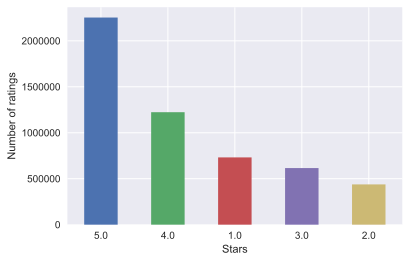

In [10]:
reviews['stars'].value_counts().plot(kind='bar')
plt.xlabel('Stars')
plt.ylabel('Number of ratings')
plt.xticks(rotation=0)
plt.show()

<strong> Most ratings are 5 stars and 2 stars are the least. The classes are not very well balanced and it might be a problem when appying machine learning alogrithms to predict ratings based on the review text. <br>
Next let's examine average user ratings. </strong>

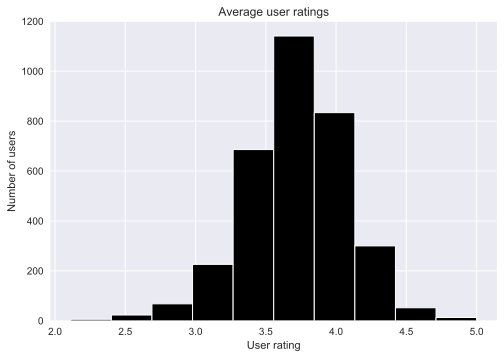

In [40]:
# Plot a histogram of average user ratings
by_users=reviews.groupby('user_id')
counts=by_users['user_id'].count()
means=by_users['stars'].mean()
# Only plot users who had more than 100 reviews
means[counts>100].hist(bins=10, lw=1, color='black', edgecolor='white')
plt.title('Average user ratings')
plt.xlabel('User rating')
plt.ylabel('Number of users')
plt.show()

In [11]:
reviews['stars']=reviews['stars'].astype(int)

In [12]:
reviews.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0.0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0.0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0.0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0.0,bv2nCi5Qv5vroFiqKGopiw


In [11]:
reviews.to_csv('reviews.csv')

In [12]:
reviews_5stars=reviews[reviews['stars']==5]

In [13]:
reviews_5stars_sample=reviews_5stars.sample(10000, axis=0)

In [14]:
text_5stars_sample=[word_tokenize(s.lower()) for s in reviews_5stars_sample['text']]

In [15]:
text_5stars_sample[0]

['i',
 'highly',
 'recommend',
 'this',
 'coffee',
 'shop',
 '.',
 'the',
 'coffee',
 ',',
 'homemade',
 'breakfast',
 'sweets',
 'and',
 'homemade',
 'soups',
 'are',
 'all',
 'very',
 'good',
 '.',
 'the',
 'owners',
 'are',
 'really',
 ',',
 'really',
 'nice',
 '!',
 'i',
 'make',
 'it',
 'a',
 'point',
 'to',
 'meet',
 'a',
 'lot',
 'of',
 'my',
 'friends',
 'there',
 'and',
 'they',
 'love',
 'the',
 'place',
 'as',
 'well',
 '!']

In [13]:
stop_words=set(stopwords.words('english'))

In [ ]:
all_words=list(itertools.chain.from_iterable(text_5stars_sample))

In [18]:
len(all_words)

1030031

In [19]:
all_words=[w for w in all_words if not w in stop_words and w.isalpha()]

In [20]:
all_word=pd.Series(all_words, index=range(len(all_words)))

In [21]:
all_word.value_counts()

great           5600
place           4393
food            3811
good            3354
service         3172
time            3078
best            2600
get             2446
one             2423
like            2412
back            2357
go              2198
would           2167
love            2157
also            2059
always          2044
really          2029
amazing         2011
friendly        1886
staff           1742
definitely      1594
delicious       1570
well            1560
nice            1536
us              1508
even            1500
recommend       1499
got             1423
could           1276
first           1264
                ... 
bunnies            1
sails              1
kaitlin            1
tonnato            1
grilling           1
clipboard          1
celabration        1
workings           1
barns              1
bribe              1
verre              1
towncar            1
supervision        1
lobato             1
capacitors         1
grayhawk           1
landis       

In [2]:
# Define a function to plot a word cloud using wordcloud package
def word_cloud(text=None, background='white', max_words=200, font_size=40, scale=3, title=None):
    wordcloud = WordCloud(
        background_color=background,
        max_words=max_words,
        max_font_size=font_size, 
        scale=scale)
    
    wordcloud.generate(text)

    fig = plt.figure(1, figsize=(12, 12), dpi=600)
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

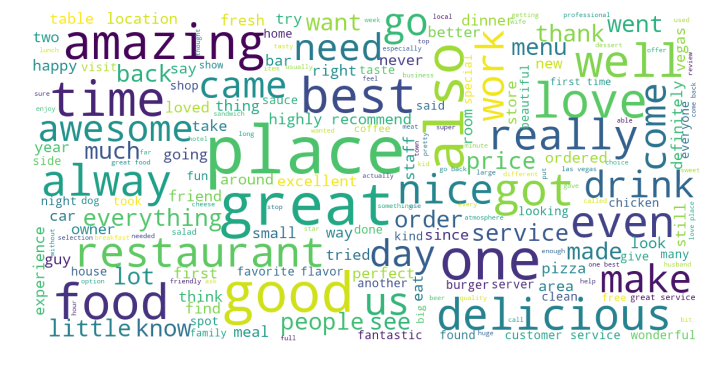

In [28]:
word_cloud(' '.join(all_words))

<strong> We can see that for 5 star ratings, the most frequent words are 'Great', 'Amazing', 'Best', 'Awesome'. This makes total sense. Now combine business data for more exploration. </strong>

In [65]:
alphas=[0.1, 1, 5, 10, 50]

In [66]:
param_grid={'alpha': alphas}

In [67]:
nb_cv=GridSearchCV(nb, param_grid, cv=5)

In [68]:
nb_cv.fit(X_train_trans, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 1, 5, 10, 50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [69]:
nb_cv.best_estimator_

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [98]:
X_train_trans.shape

(80000, 80645)

In [89]:
C_values=[0.001, 0.01, 0.1, 1, 10, 100]
solvers=['newton-cg', 'sag', 'saga', 'lbfgs']

In [94]:
param_grid={'C': C_values}

In [126]:
scores=[]
for c in C_values:
    logreg=LogisticRegression(multi_class='multinomial', solver='newton-cg', C=c)
    logreg.fit(X_train_trans, y_train)
    score=logreg.score(X_test_trans, y_test)
    scores.append(score)
print('The best score is: ', max(scores))

The best score is:  0.63815


In [132]:
logreg=LogisticRegression(multi_class='multinomial', solver='newton-cg', C=0.01, class_weight='balanced')

In [133]:
logreg.fit(X_train_trans, y_train)
logreg_pred=logreg.predict(X_test_trans)

In [139]:
logreg.score(X_train_trans, y_train)

0.688875

In [138]:
logreg.score(X_test_trans, y_test)

0.62505

In [134]:
confusion_matrix(y_test, logreg_pred, labels=[1,2,3,4,5])

array([[2054,  487,   82,   34,   66],
       [ 435,  714,  336,   76,   84],
       [ 187,  464, 1022,  527,  153],
       [ 101,  190,  818, 2261, 1305],
       [ 191,  152,  286, 1525, 6450]], dtype=int64)

In [135]:
print(classification_report(y_test, logreg_pred, target_names=['1 star', '2 stars', '3 stars', '4 stars', '5 stars']))

             precision    recall  f1-score   support

     1 star       0.69      0.75      0.72      2723
    2 stars       0.36      0.43      0.39      1645
    3 stars       0.40      0.43      0.42      2353
    4 stars       0.51      0.48      0.50      4675
    5 stars       0.80      0.75      0.77      8604

avg / total       0.63      0.63      0.63     20000



In [84]:
logreg_pred[0:20]

array([5, 1, 4, 4, 5, 5, 1, 5, 4, 1, 5, 5, 5, 3, 3, 4, 5, 3, 5, 3])

In [85]:
y_test[0:20]

array([5, 1, 4, 4, 5, 5, 1, 5, 4, 1, 5, 5, 5, 2, 4, 4, 5, 5, 5, 3])

In [87]:
confusion_matrix(y_test, logreg_pred, labels=[1,2,3,4,5])

array([[1994,  399,  142,   67,  121],
       [ 462,  534,  380,  149,  120],
       [ 178,  314,  805,  716,  340],
       [  74,  110,  583, 1942, 1966],
       [  92,   53,  156, 1298, 7005]], dtype=int64)

In [24]:
business=[]
with open('e:/data_sets/yp/dataset/business.json', encoding='utf8') as file:
    for chunk in pd.read_json(file, lines=True, chunksize=1000):
        business.append(chunk)

In [34]:
all_business=pd.concat(business, ignore_index=True)

In [35]:
len(all_business)

174567

In [36]:
all_business.to_csv('yelp_business.csv')

In [9]:
# Continue 2/6/18
# Read the two csv saved before
reviews=pd.read_csv('yelp/yelp_reviews.csv', index_col=0, low_memory=False)

In [10]:
reviews.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0.0,v0i_UHJMo_hPBq9bxWvW4w,5.0,"Love the staff, love the meat, love the place....",0.0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0.0,vkVSCC7xljjrAI4UGfnKEQ,5.0,Super simple place but amazing nonetheless. It...,0.0,bv2nCi5Qv5vroFiqKGopiw


In [ ]:
reviews['cool'].value_counts()

In [5]:
reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5261671 entries, 0 to 5261668
Data columns (total 9 columns):
business_id    5261671 non-null object
cool           5261671 non-null object
date           5261669 non-null object
funny          5261669 non-null float64
review_id      5261669 non-null object
stars          5261669 non-null float64
text           5261669 non-null object
useful         5261667 non-null float64
user_id        5261667 non-null object
dtypes: float64(3), object(6)
memory usage: 401.4+ MB


In [13]:
business=pd.read_csv('yelp/yelp_business.csv', index_col=0)

In [16]:
business['attributes'][1]

"{'BusinessParking': {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}, 'HairSpecializesIn': {'coloring': True, 'africanamerican': False, 'curly': True, 'perms': True, 'kids': True, 'extensions': True, 'asian': True, 'straightperms': True}, 'BusinessAcceptsCreditCards': True, 'RestaurantsPriceRange2': 3, 'GoodForKids': True, 'ByAppointmentOnly': False, 'WheelchairAccessible': True}"

In [23]:
business.head(2)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"['Dentists', 'General Dentistry', 'Health & Me...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,NaN,85044,22,4.0,AZ
1,3101 Washington Rd,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"['Hair Stylists', 'Hair Salons', ""Men's Hair S...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",1,40.291685,-80.104900,Stephen Szabo Salon,NaN,15317,11,3.0,PA


In [60]:
type(business['attributes'][0])

str

In [12]:
busi_reviews=reviews.merge(business_flat, on='business_id', how='left')

In [56]:
business.to_json('yelp/business_new.json', orient='records')

In [87]:
len(business)

174567

In [2]:
all_busi=[]
with open('yelp/business.json', 'r') as file:
    for line in file:
        all_busi.append(json.loads(line))

In [5]:
len(all_busi)

174567

In [8]:
json_normalize(all_busi[0])

,address,attributes.AcceptsInsurance,attributes.BusinessAcceptsCreditCards,attributes.ByAppointmentOnly,business_id,categories,city,hours.Friday,hours.Monday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9",True,True,True,FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,7:30-17:00,7:30-17:00,7:30-17:00,7:30-17:00,7:30-17:00,1,33.33069,-111.978599,Dental by Design,,85044,22,4.0,AZ


In [44]:
busi_cols=business.columns.tolist()

In [45]:
busi_cols

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'neighborhood',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [46]:
busi_cols.remove('attributes')
busi_cols.remove('hours')

In [73]:
busi_cols

['address',
 'business_id',
 'categories',
 'city',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'neighborhood',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [6]:
business_new=[]
for record in all_busi:
    business_new.append(json_normalize(record))

In [9]:
business_new[1]

,address,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking.garage,attributes.BusinessParking.lot,attributes.BusinessParking.street,attributes.BusinessParking.valet,attributes.BusinessParking.validated,attributes.ByAppointmentOnly,attributes.GoodForKids,attributes.HairSpecializesIn.africanamerican,attributes.HairSpecializesIn.asian,attributes.HairSpecializesIn.coloring,attributes.HairSpecializesIn.curly,attributes.HairSpecializesIn.extensions,attributes.HairSpecializesIn.kids,attributes.HairSpecializesIn.perms,attributes.HairSpecializesIn.straightperms,attributes.RestaurantsPriceRange2,attributes.WheelchairAccessible,business_id,categories,city,hours.Friday,hours.Monday,hours.Saturday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,3101 Washington Rd,True,False,True,False,False,False,False,True,False,True,True,True,True,True,True,True,3,True,He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,9:00-16:00,9:00-20:00,8:00-16:00,9:00-20:00,9:00-20:00,9:00-20:00,1,40.291685,-80.1049,Stephen Szabo Salon,,15317,11,3.0,PA


In [10]:
business_flat=pd.concat(business_new)

In [11]:
business_flat.reset_index(inplace=True, drop=True)

In [12]:
len(business_flat)

174567

In [13]:
business_flat.head(2)

,address,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights.friday,attributes.BestNights.monday,attributes.BestNights.saturday,attributes.BestNights.sunday,attributes.BestNights.thursday,attributes.BestNights.tuesday,attributes.BestNights.wednesday,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking.garage,attributes.BusinessParking.lot,attributes.BusinessParking.street,attributes.BusinessParking.valet,attributes.BusinessParking.validated,...,attributes.RestaurantsAttire,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi,business_id,categories,city,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,7:30-17:00,7:30-17:00,NaN,NaN,7:30-17:00,7:30-17:00,7:30-17:00,1,33.3307,-111.979,Dental by Design,,85044,22,4.0,AZ
1,3101 Washington Rd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True,False,False,False,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,True,NaN,He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,9:00-16:00,9:00-20:00,8:00-16:00,NaN,9:00-20:00,9:00-20:00,9:00-20:00,1,40.2917,-80.1049,Stephen Szabo Salon,,15317,11,3.0,PA


In [14]:
business_flat.to_csv('yelp/business_flat.csv')

In [7]:
business_flat=pd.read_csv('yelp/business_flat.csv', index_col=0)

In [8]:
business_flat.head(2)

,address,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights.friday,attributes.BestNights.monday,attributes.BestNights.saturday,attributes.BestNights.sunday,attributes.BestNights.thursday,attributes.BestNights.tuesday,attributes.BestNights.wednesday,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking.garage,attributes.BusinessParking.lot,attributes.BusinessParking.street,attributes.BusinessParking.valet,attributes.BusinessParking.validated,...,attributes.RestaurantsAttire,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi,business_id,categories,city,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FYWN1wneV18bWNgQjJ2GNg,"['Dentists', 'General Dentistry', 'Health & Me...",Ahwatukee,7:30-17:00,7:30-17:00,NaN,NaN,7:30-17:00,7:30-17:00,7:30-17:00,1,33.330690,-111.978599,Dental by Design,NaN,85044,22,4.0,AZ
1,3101 Washington Rd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True,False,False,False,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,True,NaN,He-G7vWjzVUysIKrfNbPUQ,"['Hair Stylists', 'Hair Salons', ""Men's Hair S...",McMurray,9:00-16:00,9:00-20:00,8:00-16:00,NaN,9:00-20:00,9:00-20:00,9:00-20:00,1,40.291685,-80.104900,Stephen Szabo Salon,NaN,15317,11,3.0,PA


In [7]:
business_flat.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174567 entries, 0 to 174566
Data columns (total 101 columns):
address                                         168125 non-null object
attributes.AcceptsInsurance                     10133 non-null object
attributes.AgesAllowed                          407 non-null object
attributes.Alcohol                              46167 non-null object
attributes.Ambience.casual                      44966 non-null object
attributes.Ambience.classy                      44966 non-null object
attributes.Ambience.divey                       28273 non-null object
attributes.Ambience.hipster                     44943 non-null object
attributes.Ambience.intimate                    44966 non-null object
attributes.Ambience.romantic                    44966 non-null object
attributes.Ambience.touristy                    44966 non-null object
attributes.Ambience.trendy                      44966 non-null object
attributes.Ambience.upscale                     4

In [16]:
# Let's first catch them using 'Restaurants' and 'Food'
search_str='restaurants food'
def search_in_list(categories, search_string):
    filt=[]
    for category in categories:
        if re.compile('|'.join(category), re.IGNORECASE).search(search_string):
            filt.append(True)
        else:
            filt.append(False)
    return(filt)

In [17]:
busi_reviews['categories'][0]

"['Specialty Food', 'Sandwiches', 'Restaurants', 'Imported Food', 'Ethnic Food', 'Delis', 'Food']"

In [18]:
type(busi_reviews['categories'][0])

str

In [33]:
# The following line is useful for searching a list of lists
#all_restaurants=[any([x.lower() in ['restaurants', 'food'] for x in y]) for y in busi_reviews['categories']]

In [11]:
def check_categories(categories):
    filt=[]
    for category in categories:
        if re.compile('restaurants|food', re.IGNORECASE).search(category):
            filt.append(True)
        else:
            filt.append(False)
    return(filt)
all_restaurants=check_categories(business_flat['categories'])

In [12]:
len(all_restaurants)

174567

In [51]:
type(all_restaurants)

list

In [53]:
all_restaurants[0:10]

[True, True, True, True, True, True, False, True, True, True]

In [13]:
# We can use this to filter the data frame to get restaurants data
restaurants=business_flat[all_restaurants]
rest=business_flat[[not x for x in all_restaurants]]

In [14]:
len(restaurants)

69070

In [15]:
len(rest)

105497

In [16]:
# Let's check to see if other forms of restaurants are still left in the rest
rest['categories'].value_counts()

['Nail Salons', 'Beauty & Spas']                                                                                                                       936
['Beauty & Spas', 'Nail Salons']                                                                                                                       909
['Beauty & Spas', 'Hair Salons']                                                                                                                       839
['Hair Salons', 'Beauty & Spas']                                                                                                                       781
['Auto Repair', 'Automotive']                                                                                                                          551
['Automotive', 'Auto Repair']                                                                                                                          504
[]                                                                    

In [17]:
# Let's now inner merge reviews and business to just get restaurant reviews
restaurants_reviews=all_reviews.merge(restaurants, on='business_id', how='inner')

In [18]:
len(restaurants_reviews)

3540134

In [21]:
restaurants_reviews.sample(10000, axis=0).info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2926270 to 2551365
Data columns (total 109 columns):
business_id                                     10000 non-null object
cool                                            10000 non-null int64
date                                            10000 non-null datetime64[ns]
funny                                           10000 non-null int64
review_id                                       10000 non-null object
stars_x                                         10000 non-null int64
text                                            10000 non-null object
useful                                          10000 non-null int64
user_id                                         10000 non-null object
address                                         9967 non-null object
attributes.AcceptsInsurance                     5 non-null object
attributes.AgesAllowed                          32 non-null object
attributes.Alcohol                            

In [22]:
# Drop columns with >80% null values
columns=restaurants_reviews.columns.tolist()
total=len(restaurants_reviews)
null_counts=[]
for column in columns:
    na_count=restaurants_reviews[column].isna().sum()
    if na_count/total>0.8:
        null_counts.append(True)
    else:
        null_counts.append(False)

In [25]:
null_counts[0:20]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [27]:
cols_todrop=pd.Series(columns)[null_counts]

In [29]:
cols_todrop=cols_todrop.tolist()

In [30]:
restaurants_reviews_clean=restaurants_reviews.drop(cols_todrop, axis=1)

In [33]:
restaurants_reviews_clean.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3540134 entries, 0 to 3540133
Data columns (total 66 columns):
business_id                              3540134 non-null object
cool                                     3540134 non-null int64
date                                     3540134 non-null datetime64[ns]
funny                                    3540134 non-null int64
review_id                                3540134 non-null object
stars_x                                  3540134 non-null int64
text                                     3540134 non-null object
useful                                   3540134 non-null int64
user_id                                  3540134 non-null object
address                                  3530055 non-null object
attributes.Alcohol                       3142934 non-null object
attributes.Ambience.casual               3092103 non-null object
attributes.Ambience.classy               3092103 non-null object
attributes.Ambience.divey             

In [34]:
restaurants_reviews_clean.head(2)

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.BikeParking,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking.garage,attributes.BusinessParking.lot,attributes.BusinessParking.street,attributes.BusinessParking.valet,attributes.BusinessParking.validated,attributes.Caters,attributes.DogsAllowed,attributes.GoodForKids,...,attributes.HasTV,attributes.NoiseLevel,attributes.OutdoorSeating,attributes.RestaurantsAttire,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.WheelchairAccessible,attributes.WiFi,categories,city,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars_y,state
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,False,loud,False,casual,False,True,2.0,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1,45.516373,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953,4.0,QC
1,0W4lkclzZThpx3V65bVgig,0,2011-09-28,0,FunI9om-aK5oMIIJmhMlZA,4,a must stop when you are in montreal!\n\nI was...,0,u0LXt3Uea_GidxRW1xcsfg,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,False,loud,False,casual,False,True,2.0,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1,45.516373,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953,4.0,QC


In [36]:
# Remove 'attributes.' from the column names
columns=restaurants_reviews_clean.columns.tolist()
columns_clean=[c.replace('attributes.', '') for c in columns]
columns_clean=[c.replace('.', ' ') for c in columns_clean]

In [38]:
restaurants_reviews_clean.columns=columns_clean

In [39]:
restaurants_reviews_clean.head(2)

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi,categories,city,hours Friday,hours Monday,hours Saturday,hours Sunday,hours Thursday,hours Tuesday,hours Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars_y,state
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,False,loud,False,casual,False,True,2.0,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1,45.516373,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953,4.0,QC
1,0W4lkclzZThpx3V65bVgig,0,2011-09-28,0,FunI9om-aK5oMIIJmhMlZA,4,a must stop when you are in montreal!\n\nI was...,0,u0LXt3Uea_GidxRW1xcsfg,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,False,loud,False,casual,False,True,2.0,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1,45.516373,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953,4.0,QC


In [40]:
restaurants_reviews_clean['DogsAllowed'].value_counts(dropna=False)

NaN      2752770
False     572111
True      215253
Name: DogsAllowed, dtype: int64

In [41]:
restaurants_reviews_clean.to_csv('yelp/restaurants_reviews_clean.csv')

In [47]:
# To see which attributes will help with the star rating prediction, we will look at all the attributes columns and plot them
# to see if they affect star ratings. Try alcohol first
alcohol_attr=restaurants_reviews_clean.groupby('Alcohol')['stars_x'].value_counts().unstack(level=0)

In [30]:
restaurants.groupby('Alcohol')['stars_x'].value_counts().unstack(level=0)

Alcohol,beer_and_wine,full_bar,none
stars_x,,,
1,54066,176541,112429
2,48733,172198,78825
3,76243,245241,115790
4,161007,459563,243851
5,228713,582103,387630


In [48]:
alcohol_attr

Alcohol,beer_and_wine,full_bar,none
stars_x,,,
1,54066,176541,112429
2,48733,172198,78825
3,76243,245241,115790
4,161007,459563,243851
5,228714,582103,387630


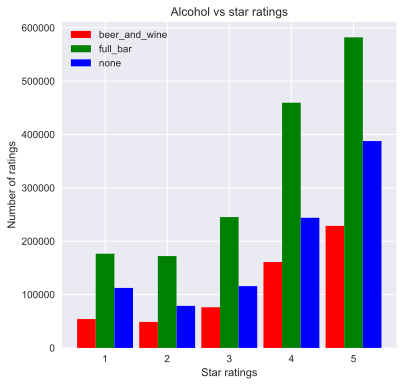

In [56]:
# Plot bar graphs to compare the three attributes
names=alcohol_attr.columns.tolist()
w=0.3
x=np.arange(5)
fig=plt.figure(figsize=(6,6))
axes=fig.add_subplot(111)
axes.bar(x, alcohol_attr[names[0]], width=w, color='r', align='center', label=names[0])
axes.bar(x+w, alcohol_attr[names[1]], width=w, color='g', align='center', label=names[1])
axes.bar(x+2*w, alcohol_attr[names[2]], width=w, color='b', align='center', label=names[2])
axes.set_xticks(x+0.3)
axes.set_xticklabels((y for y in alcohol_attr.index.tolist()))
axes.legend()
axes.set_title('Alcohol vs star ratings')
axes.set_xlabel('Star ratings')
axes.set_ylabel('Number of ratings')
plt.show()

In [2]:
restaurants=pd.read_csv('yelp/restaurants_reviews_clean.csv', index_col=0, parse_dates=True)

In [3]:
restaurants.head(2)

,business_id,cool,date.1,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi,categories,city,hours Friday,hours Monday,hours Saturday,hours Sunday,hours Thursday,hours Tuesday,hours Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars_y,state,Cuisine
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-07-22,uz7UbvVUwsg68Rok6kbqRg,0,2004-07-22,0,PbIY2aIyszb6he6J-ey67w,5,"Sehr gutes Restaurant, leckeres essen und nett...",0.0,le_brG6cwrzvWdKEGqA7YA,Leonberger Str. 97,full_bar,False,False,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False,False,...,quiet,False,casual,False,True,2.0,True,True,True,True,no,"['Restaurants', 'Indian']",Leonberg,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,1.0,48.7947,9.01037,Kashmir,NaN,71229,41.0,4.5,BW,Indian Restaurants
2004-09-15,9X-43jnj6-6ZBuBdFm7BLA,0,2004-09-15,0,03B9-gqbeGoMmPJbNzNT5w,2,Viel Auswahl täuscht über die wahre Tatsache h...,0.0,w_6miJytUt6z8oRkGjVG-A,Rosensteinstr. 22,full_bar,True,False,NaN,False,False,False,False,False,False,True,True,True,False,True,False,False,True,True,True,...,average,True,casual,False,True,2.0,True,True,True,True,free,"['American (Traditional)', 'Cocktail Bars', 'B...",Stuttgart,17:00-3:00,17:00-1:00,16:00-3:00,14:00-1:00,17:00-1:00,17:00-1:00,17:00-1:00,1.0,48.7939,9.19212,Woody's,NaN,70191,91.0,3.0,BW,American Bars Cocktail Nightlife Restaurants T...


In [25]:
restaurants.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3540134 entries, 2004-07-22 to 2017-12-11
Data columns (total 67 columns):
business_id                   3540134 non-null object
cool                          3540134 non-null int64
date.1                        3540134 non-null object
funny                         3540134 non-null int64
review_id                     3540134 non-null object
stars_x                       3540134 non-null int64
text                          3540134 non-null object
useful                        3540133 non-null float64
user_id                       3540133 non-null object
address                       3530054 non-null object
Alcohol                       3142933 non-null object
Ambience casual               3092102 non-null object
Ambience classy               3092102 non-null object
Ambience divey                2515635 non-null object
Ambience hipster              3091947 non-null object
Ambience intimate             3092102 non-null object
Ambience r

In [4]:
restaurants['stars_x'].value_counts(dropna=False).index.tolist()

[5, 4, 3, 1, 2, '5', '4', '1', '3', '2', 'False']

In [5]:
restaurants=restaurants[restaurants['stars_x']!='False']

In [6]:
restaurants['stars_x'].value_counts(dropna=False)

5    1347365
4     964553
3     489188
1     396866
2     333971
5       3531
4       2099
1        964
3        894
2        703
Name: stars_x, dtype: int64

In [7]:
restaurants['stars_x']=restaurants['stars_x'].astype(int)

In [8]:
restaurants['stars_x'].value_counts(dropna=False)

5    1350896
4     966652
3     490082
1     397830
2     334674
Name: stars_x, dtype: int64

In [14]:
restaurants['categories'].isna().sum()

1

In [15]:
restaurants['categories']=restaurants['categories'].fillna('unknown')

In [16]:
restaurants['categories'].isna().sum()

0

In [17]:
# Reformat the categories column to make it better for manipulation
categories=[re.findall('\w+', x) for x in restaurants['categories']]

In [18]:
categories=[list(set(x)) for x in categories]

In [19]:
categories=[sorted(x) for x in categories]

In [20]:
categories=[' '.join(x) for x in categories]

In [21]:
restaurants['Cuisine']=categories

In [22]:
restaurants['Cuisine'].value_counts()[0:5]

Mexican Restaurants                100907
Chinese Restaurants                 55636
Pizza Restaurants                   51420
Bars Japanese Restaurants Sushi     49216
Italian Restaurants                 47703
Name: Cuisine, dtype: int64

In [23]:
restaurants.to_csv('yelp/restaurants_reviews_clean.csv')

In [26]:
restaurants['Alcohol'].value_counts()

full_bar         1635646
none              938525
beer_and_wine     568762
Name: Alcohol, dtype: int64

In [4]:
all_attr_columns=restaurants.columns.tolist()[10: 48]

In [28]:
len(all_attr_columns)

38

In [29]:
all_attr_columns[0]

'Alcohol'

In [30]:
all_attr_columns[0:9]

['Alcohol',
 'Ambience casual',
 'Ambience classy',
 'Ambience divey',
 'Ambience hipster',
 'Ambience intimate',
 'Ambience romantic',
 'Ambience touristy',
 'Ambience trendy']

We should compare frequencies of star ratings of different categories for each attribute so that we can directly compare. The frequencies will normalize the data.

In [102]:
# Let's spot any data inconsistencies for these attribute columns
for column in all_attr_columns:
    print(column, ' : ', restaurants[column].unique())

Alcohol  :  ['full_bar' 'none' nan 'beer_and_wine']
Ambience casual  :  [False True nan]
Ambience classy  :  [False nan True]
Ambience divey  :  [nan False True]
Ambience hipster  :  [False nan True]
Ambience intimate  :  [False nan True]
Ambience romantic  :  [False nan True]
Ambience touristy  :  [False nan True]
Ambience trendy  :  [False nan True]
Ambience upscale  :  [False nan True]
BikeParking  :  [False True nan]
BusinessAcceptsCreditCards  :  [True False nan]
BusinessParking garage  :  [False True nan]
BusinessParking lot  :  [False True nan]
BusinessParking street  :  [False True nan]
BusinessParking valet  :  [False nan True]
BusinessParking validated  :  [False nan True]
Caters  :  [nan True False]
DogsAllowed  :  [False True nan]
GoodForKids  :  [False True nan]
GoodForMeal breakfast  :  [False nan True]
GoodForMeal brunch  :  [False nan True]
GoodForMeal dessert  :  [False nan True]
GoodForMeal dinner  :  [True False nan]
GoodForMeal latenight  :  [False True nan]
GoodFor

In [108]:
alcohol=restaurants.groupby('Alcohol')['stars_x'].value_counts(normalize=True).unstack(fill_value=0)

In [110]:
alcohol.T['beer_and_wine']

stars_x
1    0.095059
2    0.085683
3    0.134051
4    0.283083
5    0.402124
Name: beer_and_wine, dtype: float64

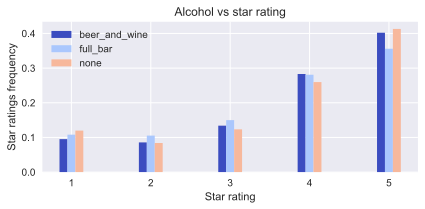

In [132]:
# Test to see how the graph would look by plotting frequencies of each star rating based on the column attributes
colors=cm.get_cmap('coolwarm')
fig, axes=plt.subplots(figsize=(6,3))
w=0.1
x=np.arange(5)
df_freq=restaurants.groupby('Alcohol')['stars_x'].value_counts(normalize=True).unstack(fill_value=0).T
for idx, col in enumerate(df_freq.columns):        
    axes.bar(x+idx*w, df_freq[col], width=w, color=colors(float(idx)/len(df_freq.columns)), align='center', label=col)
axes.set_xticks(x+w)
axes.set_xticklabels((y for y in df_freq.index))
axes.legend()
axes.set_title('Alcohol'+' vs star rating')
axes.set_xlabel('Star rating')
axes.set_ylabel('Star ratings frequency')
plt.tight_layout()
plt.show()

In [20]:
# Write a function to make multiple plots like above
def frequency_bars(columns):
    colors=cm.get_cmap('coolwarm')
    row_count=len(columns)//2
    fig, axes=plt.subplots(nrows=row_count, ncols=2, figsize=(10,3*row_count))
    w=0.1
    x=np.arange(5)
    for ind, name in enumerate(columns):
        df_freq=restaurants.groupby(name)['stars_x'].value_counts(normalize=True).unstack(fill_value=0).T
        for idx, col in enumerate(df_freq.columns):        
            axes.flat[ind].bar(x+idx*w, df_freq[col], width=w, color=colors(float(idx)/3), align='center', label=col)
        axes.flat[ind].set_xticks(x+w)
        axes.flat[ind].set_xticklabels((y for y in df_freq.index))
        axes.flat[ind].legend()
        axes.flat[ind].set_title(name+' vs star rating')
        axes.flat[ind].set_xlabel('Star rating')
        axes.flat[ind].set_ylabel('Star ratings frequency')
    plt.tight_layout()
    plt.show()

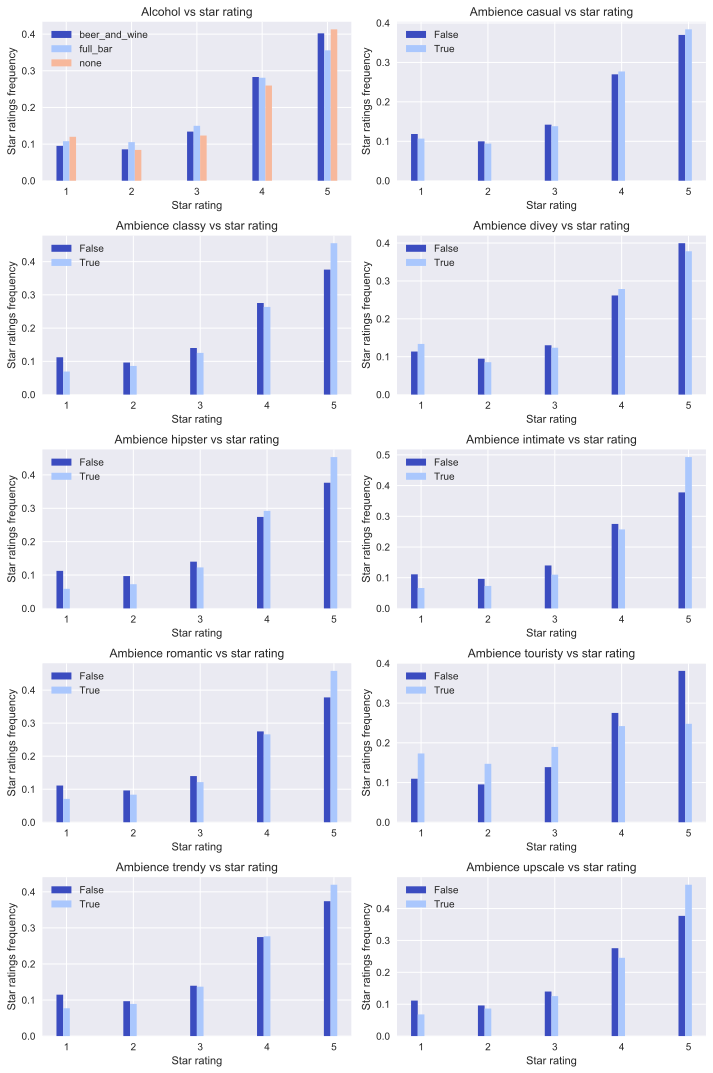

In [16]:
# Iterate through all attribute columns to see their effects
frequency_bars(all_attr_columns[0:10])

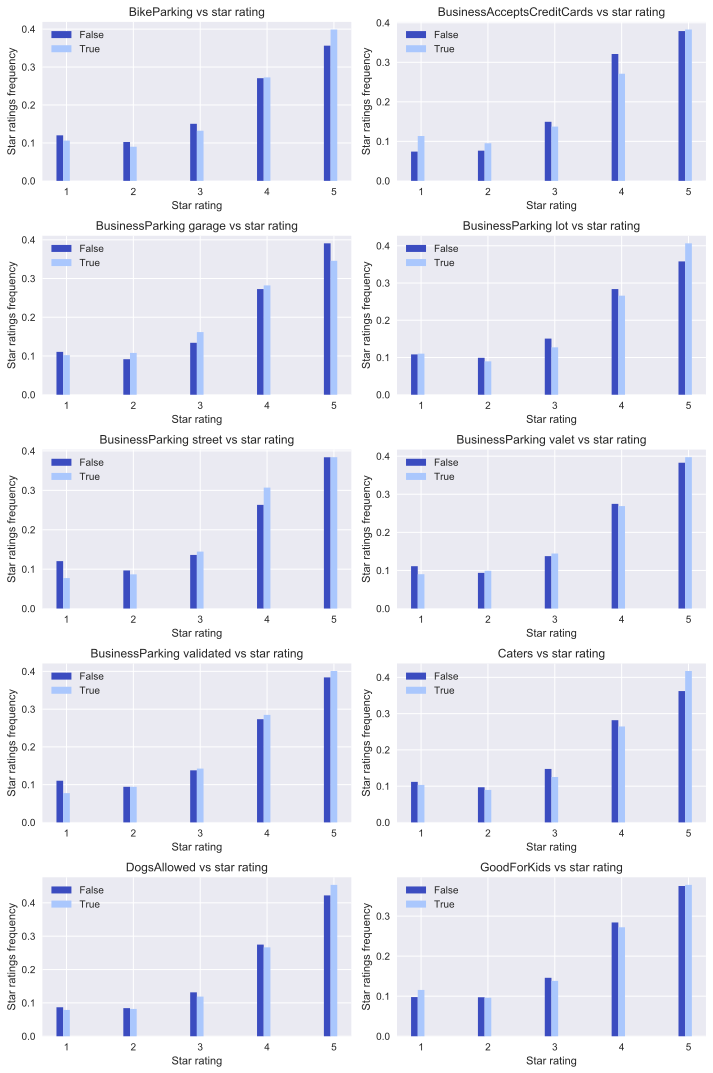

In [17]:
frequency_bars(all_attr_columns[10:20])

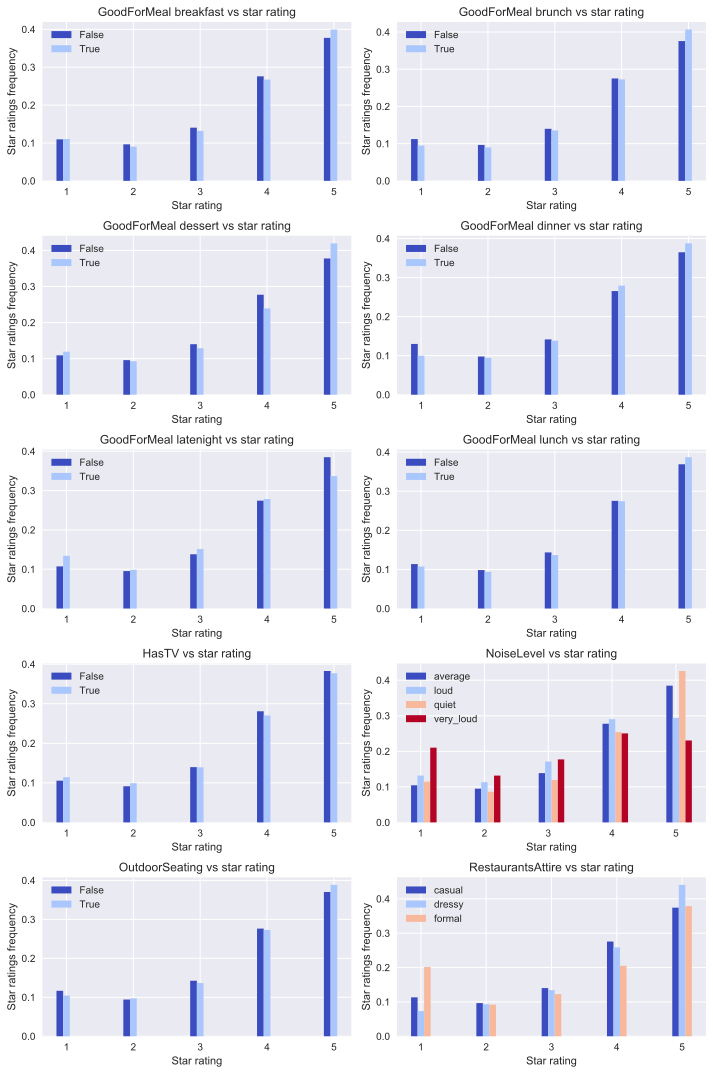

In [18]:
frequency_bars(all_attr_columns[20:30])

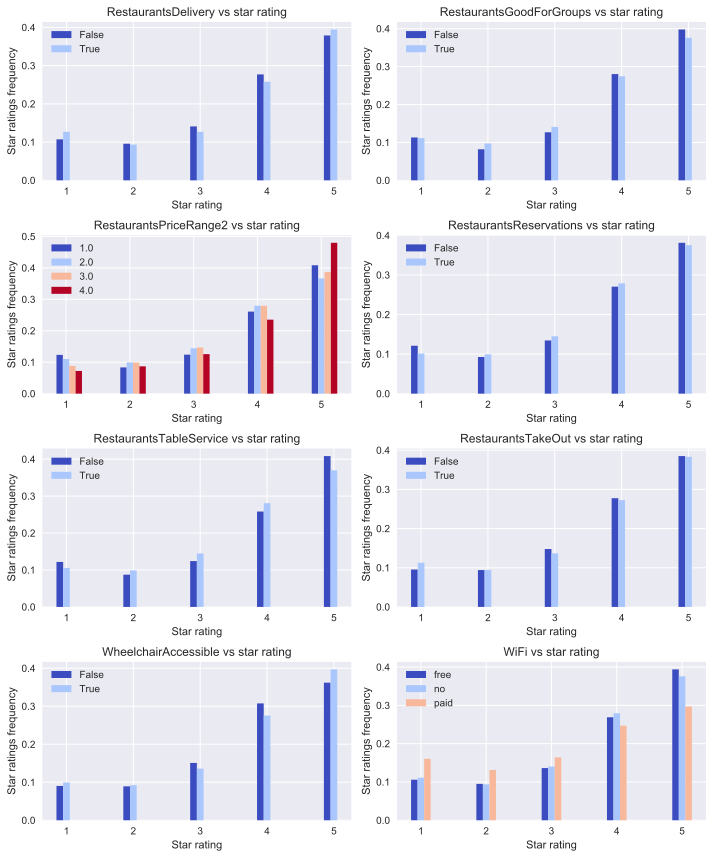

In [21]:
frequency_bars(all_attr_columns[30:40])

In [17]:
users=[]
with open('data/yelp/user.json', encoding='utf8') as file:
    for chunk in pd.read_json(file, lines=True, chunksize=1000):
        users.append(chunk)

In [18]:
all_users=pd.concat(users, ignore_index=True)

In [20]:
all_users.head(3)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.80,5174,284,5174,5175,78,299,1435,7829,7397,569,1834,16856,"[2014, 2016, 2013, 2011, 2012, 2015, 2010, 2017]",209,"[M19NwFwAXKRZzt8koF11hQ, QRcMZ8pJJBBZaKubHOoMD...",16605,Cin,272,17019,lsSiIjAKVl-QRxKjRErBeg,2010-07-13
1,3.94,1556,211,1556,1285,101,134,1295,162,2134,74,402,40110,"[2014, 2017, 2011, 2012, 2015, 2009, 2013, 200...",835,"[eoSSJzdprj3jxXyi94vDXg, QF0urZa-0bxga17ZeY-9l...",10882,Andrea,2559,83681,om5ZiponkpRqUNa3pVPiRg,2006-01-18
2,4.72,15,1,15,5,0,1,11,8,20,0,1,55,[],17,"[Oa84FFGBw1axX8O6uDkmqg, SRcWERSl4rhm-Bz9zN_J8...",4,Gabe,277,45,-lGwMGHMC_XihFJNKCJNRg,2014-10-31


In [21]:
all_users.to_csv('users.csv')

In [8]:
# Load tip.json to find the tip each user gave to the restaurant
tip=[]
with open('data/yelp/tip.json', encoding='utf8') as file:
    for chunk in pd.read_json(file, lines=True, chunksize=1000):
        tip.append(chunk)

In [9]:
all_tips=pd.concat(tip, ignore_index=True)

In [10]:
all_tips.head(3)

,business_id,date,likes,text,user_id
0,tJRDll5yqpZwehenzE2cSg,2012-07-15,0,Get here early enough to have dinner.,zcTZk7OG8ovAmh_fenH21g
1,jH19V2I9fIslnNhDzPmdkA,2015-08-12,0,Great breakfast large portions and friendly wa...,ZcLKXikTHYOnYt5VYRO5sg
2,dAa0hB2yrnHzVmsCkN4YvQ,2014-06-20,0,Nice place. Great staff. A fixture in the tow...,oaYhjqBbh18ZhU0bpyzSuw


In [11]:
all_tips.to_csv('tip.csv')

In [3]:
users=pd.read_csv('yelp/users.csv', index_col=0)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
tips=pd.read_csv('yelp/tip.csv', index_col=0)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
tips.head(3)

,Unnamed: 0,business_id,date,likes,text,user_id
0,0,tJRDll5yqpZwehenzE2cSg,2012-07-15,0,Get here early enough to have dinner.,zcTZk7OG8ovAmh_fenH21g
1,1,jH19V2I9fIslnNhDzPmdkA,2015-08-12,0,Great breakfast large portions and friendly wa...,ZcLKXikTHYOnYt5VYRO5sg
2,2,dAa0hB2yrnHzVmsCkN4YvQ,2014-06-20,0,Nice place. Great staff. A fixture in the tow...,oaYhjqBbh18ZhU0bpyzSuw


We pretty much got all the restaurants data and let's recount the most frequent words for all the 5 star ratings

In [11]:
restaurants['categories'][0]

"['Specialty Food', 'Sandwiches', 'Restaurants', 'Imported Food', 'Ethnic Food', 'Delis', 'Food']"

In [12]:
word_tokenize("['Specialty Food', 'Sandwiches', 'Restaurants', 'Imported Food', 'Ethnic Food', 'Delis', 'Food']")

['[',
 "'Specialty",
 'Food',
 "'",
 ',',
 "'Sandwiches",
 "'",
 ',',
 "'Restaurants",
 "'",
 ',',
 "'Imported",
 'Food',
 "'",
 ',',
 "'Ethnic",
 'Food',
 "'",
 ',',
 "'Delis",
 "'",
 ',',
 "'Food",
 "'",
 ']']

In [8]:
restaurants['name'].value_counts()

Starbucks                            19518
Hash House A Go Go                    9840
McDonald's                            9415
Chipotle Mexican Grill                7980
Mon Ami Gabi                          7362
Bacchanal Buffet                      7006
Buffalo Wild Wings                    5998
Wicked Spoon                          5951
In-N-Out Burger                       5598
Gordon Ramsay BurGR                   5448
Earl of Sandwich                      5329
Panera Bread                          5050
Subway                                4848
Yard House                            4737
Dunkin' Donuts                        4708
Grimaldi's Pizzeria                   4702
Denny's                               4580
The Cheesecake Factory                4519
Bachi Burger                          4463
Oregano's Pizza Bistro                4403
Pita Jungle                           4305
Tacos El Gordo                        4157
Walmart Supercenter                   4156
Five Guys  

In [5]:
restaurants_5stars_sample=restaurants[restaurants['stars_x']==5].sample(10000, axis=0)
text_5stars_sample=[word_tokenize(s.lower()) for s in restaurants_5stars_sample['text']]

In [6]:
stop_words=set(stopwords.words('english'))

In [7]:
all_words=list(itertools.chain.from_iterable(text_5stars_sample))

In [8]:
len(all_words)

1016464

In [9]:
all_words=[w for w in all_words if not w in stop_words and w.isalpha()]

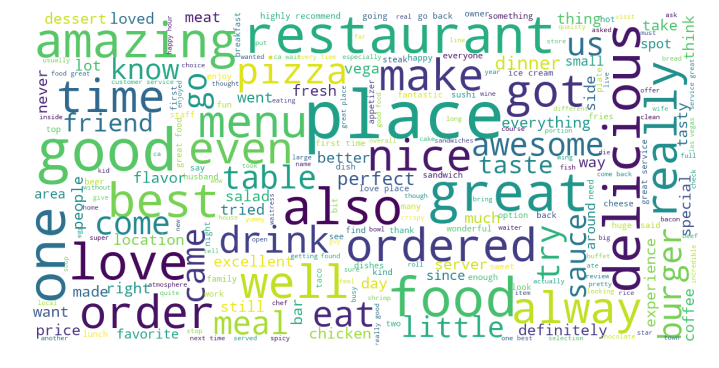

In [10]:
word_cloud(' '.join(all_words), max_words=1000)

Now let's do some time series analysis and see how ratings change over time using the 'date' column

In [5]:
date=pd.to_datetime(restaurants['date'])

In [6]:
type(date)

pandas.core.series.Series

In [7]:
date.dtype

dtype('<M8[ns]')

In [8]:
restaurants.index=date

In [9]:
restaurants.head(3)

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi,categories,city,hours Friday,hours Monday,hours Saturday,hours Sunday,hours Thursday,hours Tuesday,hours Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars_y,state,Cuisine
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-28,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0.0,bv2nCi5Qv5vroFiqKGopiw,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,loud,False,casual,False,True,2.0,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1.0,45.516373,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953.0,4.0,QC,Delis Ethnic Food Imported Restaurants Sandwic...
2011-09-28,0W4lkclzZThpx3V65bVgig,0,2011-09-28,0,FunI9om-aK5oMIIJmhMlZA,4,a must stop when you are in montreal!\r\r\n\r\...,0.0,u0LXt3Uea_GidxRW1xcsfg,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,loud,False,casual,False,True,2.0,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1.0,45.516373,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953.0,4.0,QC,Delis Ethnic Food Imported Restaurants Sandwic...
2016-02-22,0W4lkclzZThpx3V65bVgig,2,2016-02-22,1,ufI413zxZqGwIBIInnM5Rg,4,*Schwartz's has become a Montreal's famous lan...,4.0,xYciRtVZ1PW4IxSX4oJ1aw,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,loud,False,casual,False,True,2.0,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1.0,45.516373,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953.0,4.0,QC,Delis Ethnic Food Imported Restaurants Sandwic...


In [36]:
restaurants.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3540134 entries, 2016-05-28 to 2017-08-04
Data columns (total 67 columns):
business_id                   3540134 non-null object
cool                          3540134 non-null object
date                          3540134 non-null object
funny                         3540134 non-null object
review_id                     3540134 non-null object
stars_x                       3540134 non-null int32
text                          3540134 non-null object
useful                        3540133 non-null object
user_id                       3540133 non-null object
address                       3530054 non-null object
Alcohol                       3142933 non-null object
Ambience casual               3092102 non-null object
Ambience classy               3092102 non-null object
Ambience divey                2515635 non-null object
Ambience hipster              3091947 non-null object
Ambience intimate             3092102 non-null object
Ambience 

In [10]:
restaurants.sort_index(inplace=True)

In [11]:
restaurants.head(2)

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi,categories,city,hours Friday,hours Monday,hours Saturday,hours Sunday,hours Thursday,hours Tuesday,hours Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars_y,state,Cuisine
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-07-22,uz7UbvVUwsg68Rok6kbqRg,0,2004-07-22,0,PbIY2aIyszb6he6J-ey67w,5,"Sehr gutes Restaurant, leckeres essen und nett...",0.0,le_brG6cwrzvWdKEGqA7YA,Leonberger Str. 97,full_bar,False,False,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False,False,...,quiet,False,casual,False,True,2.0,True,True,True,True,no,"['Restaurants', 'Indian']",Leonberg,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,1.0,48.7947,9.01037,Kashmir,NaN,71229,41.0,4.5,BW,Indian Restaurants
2004-09-15,9X-43jnj6-6ZBuBdFm7BLA,0,2004-09-15,0,03B9-gqbeGoMmPJbNzNT5w,2,Viel Auswahl täuscht über die wahre Tatsache h...,0.0,w_6miJytUt6z8oRkGjVG-A,Rosensteinstr. 22,full_bar,True,False,NaN,False,False,False,False,False,False,True,True,True,False,True,False,False,True,True,True,...,average,True,casual,False,True,2.0,True,True,True,True,free,"['American (Traditional)', 'Cocktail Bars', 'B...",Stuttgart,17:00-3:00,17:00-1:00,16:00-3:00,14:00-1:00,17:00-1:00,17:00-1:00,17:00-1:00,1.0,48.7939,9.19212,Woody's,NaN,70191,91.0,3.0,BW,American Bars Cocktail Nightlife Restaurants T...


In [12]:
# 5-30-18
restaurants.to_csv('yelp/restaurants_reviews_clean.csv')

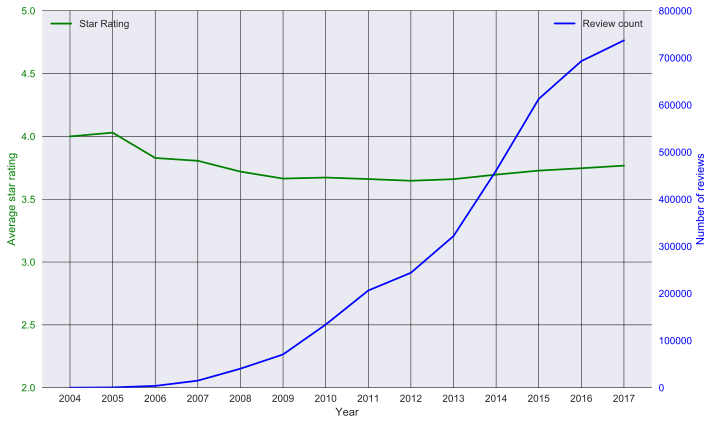

In [14]:
# Let's see how many reviews were given during each year
data1=restaurants['review_id'].resample('A').count()
data2=restaurants['stars_x'].resample('A').apply(np.mean)
years=data1.index.year.tolist()

fig, ax1=plt.subplots(figsize=(10,6))

ax1.set_xlabel('Year')
ax1.set_ylabel('Average star rating', color='green')
ax1.set_ylim((2,5))
ax1.plot(years, data2.values, color='green', label='Star Rating')
ax1.set_xticks(years)
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(linestyle='-', linewidth='0.5', color='black')
ax1.legend(loc='upper left')

ax2=ax1.twinx()
ax2.set_ylabel('Number of reviews', color='blue')
ax2.set_ylim((0, 800000))
ax2.plot(years, data1.values, color='blue', label='Review count')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Average star rating went down then slowly climbed up after 2012, however, total review count is increasing over the years. So year might be a good feature to use when doing star rating prediction.

We can also see monthly average rating change over these years

In [77]:
restaurants['Month']=restaurants.index.month

In [80]:
monthly_rating=restaurants.groupby('Month')['stars_x'].apply(np.mean)

In [82]:
monthly_rating.head()

Month
1    3.730957
2    3.714029
3    3.705432
4    3.716395
5    3.709593
Name: stars_x, dtype: float64

In [83]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

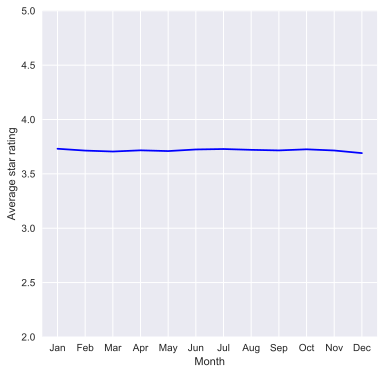

In [91]:
plt.figure(figsize=(6,6))
plt.plot(monthly_rating.index, monthly_rating.values, color='blue')
plt.xlabel('Month')
plt.ylabel('Average star rating')
plt.ylim((2,5))
plt.xticks(monthly_rating.index, months)
plt.show()

Looks like monthly average rating doesn't change much

Do different types of restaurants have different star rating distributions? Let's check a few of them.

In [23]:
all_cuisines=restaurants['Cuisine'].value_counts().index.tolist()

In [24]:
all_cuisines[0:10]

['Mexican Restaurants',
 'Chinese Restaurants',
 'Pizza Restaurants',
 'Bars Japanese Restaurants Sushi',
 'Italian Restaurants',
 'Coffee Food Tea',
 'Italian Pizza Restaurants',
 'Restaurants Thai',
 'Restaurants Vietnamese',
 'Burgers Fast Food Restaurants']

We should have a baseline to compare to so I think the average star ratings for all cuisines might be a good metric.

In [53]:
# Let's only take top 10 cuisines to compare
top_10_cuisines=restaurants[restaurants['Cuisine'].isin(all_cuisines[0:10])]
top_10_rating_dis=top_10_cuisines.groupby('Cuisine')['stars_x'].value_counts().unstack(fill_value=0)

In [52]:
top_10_rating_dis.head(3)

stars_x,1,2,3,4,5
Cuisine,,,,,
Bars Japanese Restaurants Sushi,5326,4767,6797,13538,18788
Burgers Fast Food Restaurants,8445,2869,3172,4405,5362
Chinese Restaurants,8503,5878,8756,16483,16016


In [58]:
average_rating_dis=top_10_rating_dis.mean(axis=0)

In [59]:
average_rating_dis

stars_x
1     6643.9
2     4885.7
3     6682.1
4    12926.9
5    16689.3
dtype: float64

In [60]:
average_rating_dis

pandas.core.series.Series

Instead of comparing absolute counts, we should compare frequency to normalize all ratings as some restaurants receive more ratings than others.

In [62]:
average_rating_dis=average_rating_dis.reset_index()

In [63]:
average_rating_dis

,stars_x,0
0,1,6643.9
1,2,4885.7
2,3,6682.1
3,4,12926.9
4,5,16689.3


In [64]:
average_rating_dis.columns=['Star rating', 'Counts']

In [67]:
average_rating_dis['Freq']=average_rating_dis['Counts'].apply(lambda x: x/np.sum(average_rating_dis['Counts']))

In [68]:
average_rating_dis

,Star rating,Counts,Freq
0,1,6643.9,0.138913
1,2,4885.7,0.102152
2,3,6682.1,0.139711
3,4,12926.9,0.270279
4,5,16689.3,0.348945


In [70]:
top_10_rating_dis['Total']=top_10_rating_dis.sum(axis=1)

In [74]:
for i in range(5):
    top_10_rating_dis['Freq of '+ str(i+1)]=top_10_rating_dis.iloc[:, i]/top_10_rating_dis['Total']

In [75]:
top_10_rating_dis

stars_x,1,2,3,4,5,Total,Freq of 1,Freq of 2,Freq of 3,Freq of 4,Freq of 5
Cuisine,,,,,,,,,,,
Bars Japanese Restaurants Sushi,5326,4767,6797,13538,18788,49216,0.108217,0.096859,0.138105,0.275073,0.381746
Burgers Fast Food Restaurants,8445,2869,3172,4405,5362,24253,0.348204,0.118295,0.130788,0.181627,0.221086
Chinese Restaurants,8503,5878,8756,16483,16016,55636,0.152833,0.105651,0.157380,0.296265,0.287871
Coffee Food Tea,6003,4361,6369,12456,17288,46477,0.129161,0.093831,0.137036,0.268004,0.371969
Italian Pizza Restaurants,4621,4012,5428,11343,15823,41227,0.112087,0.097315,0.131661,0.275135,0.383802
Italian Restaurants,5075,5445,6955,12884,17344,47703,0.106387,0.114144,0.145798,0.270088,0.363583
Mexican Restaurants,14066,11238,13908,26108,35587,100907,0.139396,0.111370,0.137830,0.258733,0.352671
Pizza Restaurants,8521,4654,6379,13361,18505,51420,0.165714,0.090510,0.124057,0.259841,0.359879
Restaurants Thai,3246,3236,5025,10949,13890,36346,0.089308,0.089033,0.138255,0.301244,0.382160


Now let's compare each restaurant to average rating frequencies

In [78]:
names=top_10_rating_dis.index.tolist()

In [79]:
dis_for_plot=top_10_rating_dis.drop([1,2,3,4,5, 'Total'], axis=1).T

In [80]:
dis_for_plot

Cuisine,Bars Japanese Restaurants Sushi,Burgers Fast Food Restaurants,Chinese Restaurants,Coffee Food Tea,Italian Pizza Restaurants,Italian Restaurants,Mexican Restaurants,Pizza Restaurants,Restaurants Thai,Restaurants Vietnamese
stars_x,,,,,,,,,,
Freq of 1,0.108217,0.348204,0.152833,0.129161,0.112087,0.106387,0.139396,0.165714,0.089308,0.104925
Freq of 2,0.096859,0.118295,0.105651,0.093831,0.097315,0.114144,0.111370,0.090510,0.089033,0.095521
Freq of 3,0.138105,0.130788,0.157380,0.137036,0.131661,0.145798,0.137830,0.124057,0.138255,0.160676
Freq of 4,0.275073,0.181627,0.296265,0.268004,0.275135,0.270088,0.258733,0.259841,0.301244,0.308520
Freq of 5,0.381746,0.221086,0.287871,0.371969,0.383802,0.363583,0.352671,0.359879,0.382160,0.330358


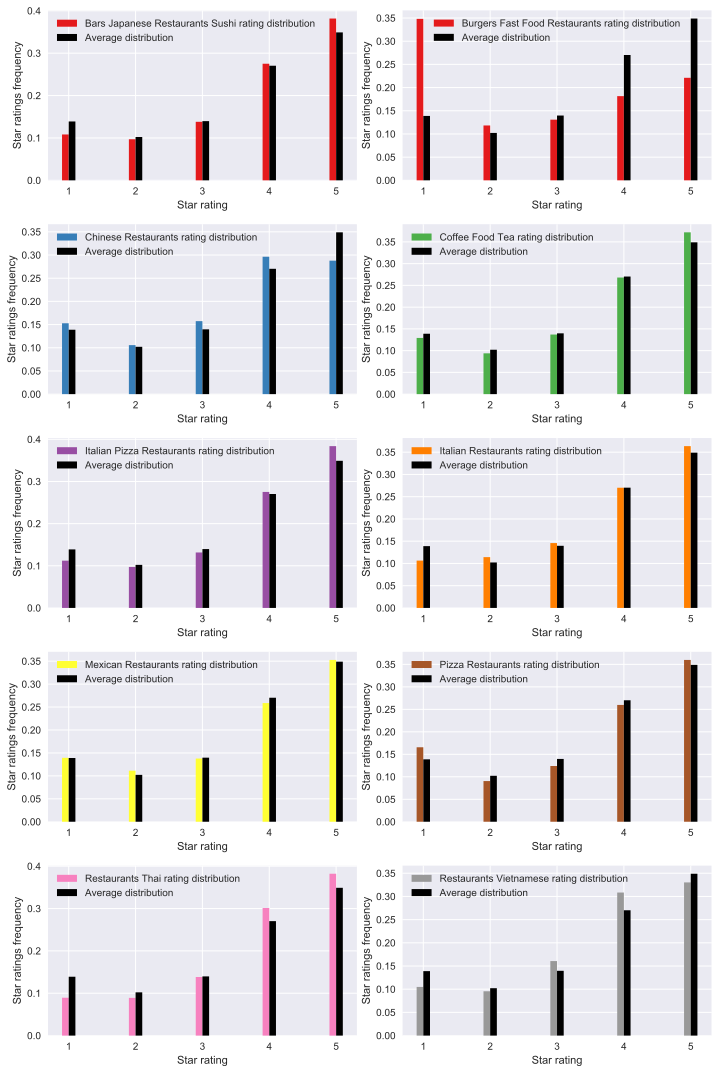

In [97]:
colors=cm.get_cmap('Set1')
fig, axes=plt.subplots(nrows=5, ncols=2, figsize=(10,15))
w=0.1
x=np.arange(len(dis_for_plot))
for idx, name in enumerate(names):
    axes.flat[idx].bar(x, dis_for_plot[name], width=w, color=colors(float(idx)/10), align='center', 
                       label=name+ ' rating distribution')
    axes.flat[idx].bar(x+w, average_rating_dis['Freq'], width=w, color='black', align='center', label='Average distribution')
    axes.flat[idx].set_xticks(x+w/2)
    axes.flat[idx].set_xticklabels((y for y in average_rating_dis['Star rating']))
    axes.flat[idx].legend()
    axes.flat[idx].set_xlabel('Star rating')
    axes.flat[idx].set_ylabel('Star ratings frequency')
plt.tight_layout()
plt.show()

In [22]:
# Calculate hours each restaurant is open for
form='%H:%M'

In [23]:
# Extract time columns
time_columns=[x for x in restaurants.columns if x.startswith('hours') ]

In [24]:
time_columns

['hours Friday',
 'hours Monday',
 'hours Saturday',
 'hours Sunday',
 'hours Thursday',
 'hours Tuesday',
 'hours Wednesday']

In [8]:
for col in time_columns:
    restaurants[col]=restaurants[col].fillna('0:00-0:00')

In [9]:
restaurants[time_columns].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3540134 entries, 2004-07-22 to 2017-12-11
Data columns (total 7 columns):
hours Friday       3540134 non-null object
hours Monday       3540134 non-null object
hours Saturday     3540134 non-null object
hours Sunday       3540134 non-null object
hours Thursday     3540134 non-null object
hours Tuesday      3540134 non-null object
hours Wednesday    3540134 non-null object
dtypes: object(7)
memory usage: 216.1+ MB


In [10]:
restaurants['hours Friday'].apply(len).value_counts()

11    1639968
10    1357030
9      543136
Name: hours Friday, dtype: int64

In [11]:
# Define a function to parse the time into datetime object for calculating time difference
def time_diff(string):
    if len(string)>=9:
        t1=datetime.strptime(string[0:string.index('-')], form)
        t2=datetime.strptime(string[(string.index('-')+1):], form)
        t_delta=t2-t1
        hour_diff=t_delta.seconds/3600
    else:
        hour_diff=0
    return(hour_diff)

In [12]:
hours_dict={}
for col in time_columns:
    hours=restaurants[col].apply(time_diff)
    hours_dict['Total '+col]=hours

In [13]:
for key, value in hours_dict.items():
    restaurants[key]=value

In [14]:
restaurants.head(3)

,business_id,cool,date.1,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi,categories,city,hours Friday,hours Monday,hours Saturday,hours Sunday,hours Thursday,hours Tuesday,hours Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars_y,state,Cuisine,Total hours Friday,Total hours Monday,Total hours Saturday,Total hours Sunday,Total hours Thursday,Total hours Tuesday,Total hours Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-07-22,uz7UbvVUwsg68Rok6kbqRg,0,2004-07-22,0,PbIY2aIyszb6he6J-ey67w,5,"Sehr gutes Restaurant, leckeres essen und nett...",0.0,le_brG6cwrzvWdKEGqA7YA,Leonberger Str. 97,full_bar,False,False,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False,False,...,True,True,True,no,"['Restaurants', 'Indian']",Leonberg,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,1.0,48.794700,9.010370,Kashmir,NaN,71229,41.0,4.5,BW,Indian Restaurants,5.5,5.5,5.5,5.5,5.5,5.5,5.5
2004-09-15,9X-43jnj6-6ZBuBdFm7BLA,0,2004-09-15,0,03B9-gqbeGoMmPJbNzNT5w,2,Viel Auswahl täuscht über die wahre Tatsache h...,0.0,w_6miJytUt6z8oRkGjVG-A,Rosensteinstr. 22,full_bar,True,False,NaN,False,False,False,False,False,False,True,True,True,False,True,False,False,True,True,True,...,True,True,True,free,"['American (Traditional)', 'Cocktail Bars', 'B...",Stuttgart,17:00-3:00,17:00-1:00,16:00-3:00,14:00-1:00,17:00-1:00,17:00-1:00,17:00-1:00,1.0,48.793900,9.192120,Woody's,NaN,70191,91.0,3.0,BW,American Bars Cocktail Nightlife Restaurants T...,10.0,8.0,11.0,11.0,8.0,8.0,8.0
2004-10-12,PD2MAlYYi9HCqPH7IBKwTg,1,2004-10-12,0,_CRpX4FGBkxie_1q0-DbjQ,5,Hole in the wall burrito joint with the BEST b...,1.0,sE3ge33huDcNJGW3V4obww,606 S 6th St,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,NaN,NaN,True,...,False,True,True,NaN,"['Mexican', 'Restaurants']",Champaign,0:00-0:00,0:00-0:00,0:00-0:00,0:00-0:00,0:00-0:00,0:00-0:00,0:00-0:00,0.0,40.111016,-88.230183,La Bamba,NaN,61820,18.0,4.0,IL,Mexican Restaurants,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# 6-3-18 morning
restaurants.to_csv('yelp/restaurants_reviews_clean.csv')

In [4]:
# Let's create two features: total hours weekdays and total hours weekends
restaurants['Total hours weekdays']=restaurants[['Total hours Monday', 'Total hours Tuesday', 'Total hours Wednesday', 
                                                 'Total hours Thursday', 'Total hours Friday']].sum(axis=1)

In [5]:
restaurants['Total hours weekends']=restaurants['Total hours Saturday']+restaurants['Total hours Sunday']

In [6]:
restaurants.head(2)

,business_id,cool,date.1,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,WheelchairAccessible,WiFi,categories,city,hours Friday,hours Monday,hours Saturday,hours Sunday,hours Thursday,hours Tuesday,hours Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars_y,state,Cuisine,Total hours Friday,Total hours Monday,Total hours Saturday,Total hours Sunday,Total hours Thursday,Total hours Tuesday,Total hours Wednesday,Total hours weekdays,Total hours weekends
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-07-22,uz7UbvVUwsg68Rok6kbqRg,0,2004-07-22,0,PbIY2aIyszb6he6J-ey67w,5,"Sehr gutes Restaurant, leckeres essen und nett...",0.0,le_brG6cwrzvWdKEGqA7YA,Leonberger Str. 97,full_bar,False,False,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False,False,...,True,no,"['Restaurants', 'Indian']",Leonberg,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,17:30-23:00,1.0,48.7947,9.01037,Kashmir,NaN,71229,41.0,4.5,BW,Indian Restaurants,5.5,5.5,5.5,5.5,5.5,5.5,5.5,27.5,11.0
2004-09-15,9X-43jnj6-6ZBuBdFm7BLA,0,2004-09-15,0,03B9-gqbeGoMmPJbNzNT5w,2,Viel Auswahl täuscht über die wahre Tatsache h...,0.0,w_6miJytUt6z8oRkGjVG-A,Rosensteinstr. 22,full_bar,True,False,NaN,False,False,False,False,False,False,True,True,True,False,True,False,False,True,True,True,...,True,free,"['American (Traditional)', 'Cocktail Bars', 'B...",Stuttgart,17:00-3:00,17:00-1:00,16:00-3:00,14:00-1:00,17:00-1:00,17:00-1:00,17:00-1:00,1.0,48.7939,9.19212,Woody's,NaN,70191,91.0,3.0,BW,American Bars Cocktail Nightlife Restaurants T...,10.0,8.0,11.0,11.0,8.0,8.0,8.0,42.0,22.0


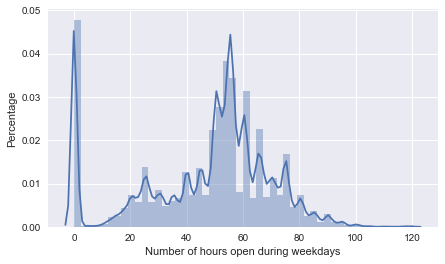

In [49]:
plt.figure(figsize=(7,4))
sns.distplot(restaurants['Total hours weekdays'])
plt.xlabel('Number of hours open during weekdays')
plt.ylabel('Percentage')
plt.show()

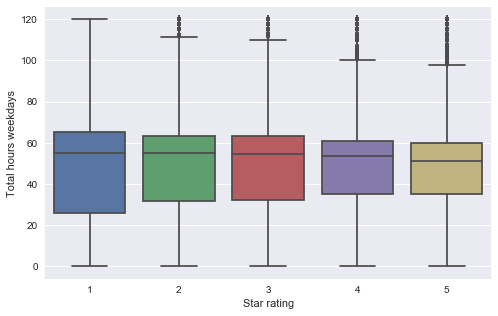

In [12]:
# Let's do a box plot to see if there is nay relationship between star ratings and hours
plt.figure(figsize=(8,5))
sns.boxplot(x='stars_x', y='Total hours weekdays', data=restaurants)
plt.xlabel('Star rating')
plt.show()

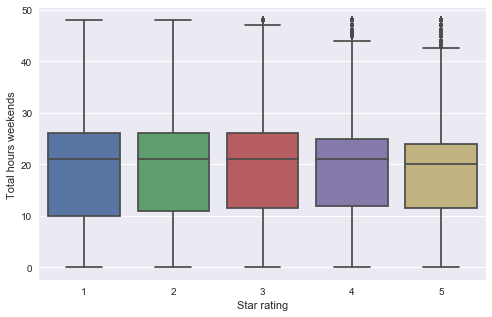

In [13]:
# Let's do a box plot to see if there is nay relationship between star ratings and hours
plt.figure(figsize=(8,5))
sns.boxplot(x='stars_x', y='Total hours weekends', data=restaurants)
plt.xlabel('Star rating')
plt.show()

There is no obvious relationship between number of hours and ratings. Let's look at individual days.

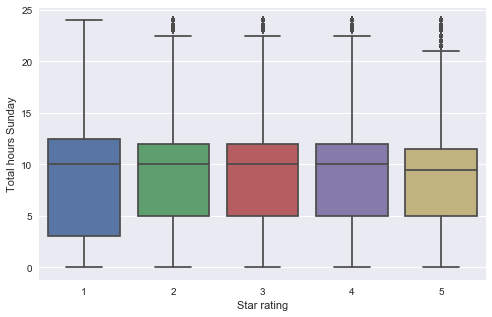

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(x='stars_x', y='Total hours Sunday', data=restaurants)
plt.xlabel('Star rating')
plt.show()

Total hours don't seem to have any effect on star ratings but what about opening early or closing late? We can extract opening time and closing for each day of the week and then look at distribution of star ratings.

In [25]:
for col in time_columns:
    restaurants[col[(col.index(' ')+1):]+' open at']=restaurants[col].apply(lambda x: x[0:x.index('-')])
    restaurants[col[(col.index(' ')+1):]+' close at']=restaurants[col].apply(lambda x: x[(x.index('-')+1):])

In [26]:
restaurants.head(3)

,business_id,cool,date.1,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,name,neighborhood,postal_code,review_count,stars_y,state,Cuisine,Total hours Friday,Total hours Monday,Total hours Saturday,Total hours Sunday,Total hours Thursday,Total hours Tuesday,Total hours Wednesday,Total hours weekdays,Total hours weekends,Friday open at,Friday close at,Monday open at,Monday close at,Saturday open at,Saturday close at,Sunday open at,Sunday close at,Thursday open at,Thursday close at,Tuesday open at,Tuesday close at,Wednesday open at,Wednesday close at
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-07-22,uz7UbvVUwsg68Rok6kbqRg,0,2004-07-22,0,PbIY2aIyszb6he6J-ey67w,5,"Sehr gutes Restaurant, leckeres essen und nett...",0.0,le_brG6cwrzvWdKEGqA7YA,Leonberger Str. 97,full_bar,False,False,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False,False,...,Kashmir,NaN,71229,41.0,4.5,BW,Indian Restaurants,5.5,5.5,5.5,5.5,5.5,5.5,5.5,27.5,11.0,17:30,23:00,17:30,23:00,17:30,23:00,17:30,23:00,17:30,23:00,17:30,23:00,17:30,23:00
2004-09-15,9X-43jnj6-6ZBuBdFm7BLA,0,2004-09-15,0,03B9-gqbeGoMmPJbNzNT5w,2,Viel Auswahl täuscht über die wahre Tatsache h...,0.0,w_6miJytUt6z8oRkGjVG-A,Rosensteinstr. 22,full_bar,True,False,NaN,False,False,False,False,False,False,True,True,True,False,True,False,False,True,True,True,...,Woody's,NaN,70191,91.0,3.0,BW,American Bars Cocktail Nightlife Restaurants T...,10.0,8.0,11.0,11.0,8.0,8.0,8.0,42.0,22.0,17:00,3:00,17:00,1:00,16:00,3:00,14:00,1:00,17:00,1:00,17:00,1:00,17:00,1:00
2004-10-12,PD2MAlYYi9HCqPH7IBKwTg,1,2004-10-12,0,_CRpX4FGBkxie_1q0-DbjQ,5,Hole in the wall burrito joint with the BEST b...,1.0,sE3ge33huDcNJGW3V4obww,606 S 6th St,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,NaN,NaN,True,...,La Bamba,NaN,61820,18.0,4.0,IL,Mexican Restaurants,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0:00,0:00,0:00,0:00,0:00,0:00,0:00,0:00,0:00,0:00,0:00,0:00,0:00,0:00


In [27]:
# Convert the time stamp to a float for comparison. For time ends on the next day, add 24 to it to reflect the actual differecen.
Weekdays=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [28]:
for day in Weekdays:
    restaurants[day+' open at']=restaurants[day+ ' open at'].apply(lambda x: x.replace(':', '.')).astype(float)
    restaurants[day+' close at']=restaurants[day+ ' close at'].apply(lambda x: x.replace(':', '.')).astype(float)

In [29]:
restaurants[[x+' open at' for x in Weekdays]].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3540134 entries, 2004-07-22 to 2017-12-11
Data columns (total 7 columns):
Monday open at       3540134 non-null float64
Tuesday open at      3540134 non-null float64
Wednesday open at    3540134 non-null float64
Thursday open at     3540134 non-null float64
Friday open at       3540134 non-null float64
Saturday open at     3540134 non-null float64
Sunday open at       3540134 non-null float64
dtypes: float64(7)
memory usage: 296.1 MB


In [30]:
restaurants.head(2)

,business_id,cool,date.1,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,name,neighborhood,postal_code,review_count,stars_y,state,Cuisine,Total hours Friday,Total hours Monday,Total hours Saturday,Total hours Sunday,Total hours Thursday,Total hours Tuesday,Total hours Wednesday,Total hours weekdays,Total hours weekends,Friday open at,Friday close at,Monday open at,Monday close at,Saturday open at,Saturday close at,Sunday open at,Sunday close at,Thursday open at,Thursday close at,Tuesday open at,Tuesday close at,Wednesday open at,Wednesday close at
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-07-22,uz7UbvVUwsg68Rok6kbqRg,0,2004-07-22,0,PbIY2aIyszb6he6J-ey67w,5,"Sehr gutes Restaurant, leckeres essen und nett...",0.0,le_brG6cwrzvWdKEGqA7YA,Leonberger Str. 97,full_bar,False,False,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False,False,...,Kashmir,NaN,71229,41.0,4.5,BW,Indian Restaurants,5.5,5.5,5.5,5.5,5.5,5.5,5.5,27.5,11.0,17.3,23.0,17.3,23.0,17.3,23.0,17.3,23.0,17.3,23.0,17.3,23.0,17.3,23.0
2004-09-15,9X-43jnj6-6ZBuBdFm7BLA,0,2004-09-15,0,03B9-gqbeGoMmPJbNzNT5w,2,Viel Auswahl täuscht über die wahre Tatsache h...,0.0,w_6miJytUt6z8oRkGjVG-A,Rosensteinstr. 22,full_bar,True,False,NaN,False,False,False,False,False,False,True,True,True,False,True,False,False,True,True,True,...,Woody's,NaN,70191,91.0,3.0,BW,American Bars Cocktail Nightlife Restaurants T...,10.0,8.0,11.0,11.0,8.0,8.0,8.0,42.0,22.0,17.0,3.0,17.0,1.0,16.0,3.0,14.0,1.0,17.0,1.0,17.0,1.0,17.0,1.0


In [37]:
# Add 24 hours to time ending on next day 
def add_day(time):
    if len(str(round(time)))==1 and  time!=0:
        time=time+24
    return(time)

In [38]:
for day in Weekdays:
    restaurants[day+' close at']=restaurants[day+ ' close at'].apply(add_day)

In [40]:
restaurants.head(2)

,business_id,cool,date.1,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,name,neighborhood,postal_code,review_count,stars_y,state,Cuisine,Total hours Friday,Total hours Monday,Total hours Saturday,Total hours Sunday,Total hours Thursday,Total hours Tuesday,Total hours Wednesday,Total hours weekdays,Total hours weekends,Friday open at,Friday close at,Monday open at,Monday close at,Saturday open at,Saturday close at,Sunday open at,Sunday close at,Thursday open at,Thursday close at,Tuesday open at,Tuesday close at,Wednesday open at,Wednesday close at
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-07-22,uz7UbvVUwsg68Rok6kbqRg,0,2004-07-22,0,PbIY2aIyszb6he6J-ey67w,5,"Sehr gutes Restaurant, leckeres essen und nett...",0.0,le_brG6cwrzvWdKEGqA7YA,Leonberger Str. 97,full_bar,False,False,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False,False,...,Kashmir,NaN,71229,41.0,4.5,BW,Indian Restaurants,5.5,5.5,5.5,5.5,5.5,5.5,5.5,27.5,11.0,17.3,23.0,17.3,23.0,17.3,23.0,17.3,23.0,17.3,23.0,17.3,23.0,17.3,23.0
2004-09-15,9X-43jnj6-6ZBuBdFm7BLA,0,2004-09-15,0,03B9-gqbeGoMmPJbNzNT5w,2,Viel Auswahl täuscht über die wahre Tatsache h...,0.0,w_6miJytUt6z8oRkGjVG-A,Rosensteinstr. 22,full_bar,True,False,NaN,False,False,False,False,False,False,True,True,True,False,True,False,False,True,True,True,...,Woody's,NaN,70191,91.0,3.0,BW,American Bars Cocktail Nightlife Restaurants T...,10.0,8.0,11.0,11.0,8.0,8.0,8.0,42.0,22.0,17.0,27.0,17.0,25.0,16.0,27.0,14.0,25.0,17.0,25.0,17.0,25.0,17.0,25.0


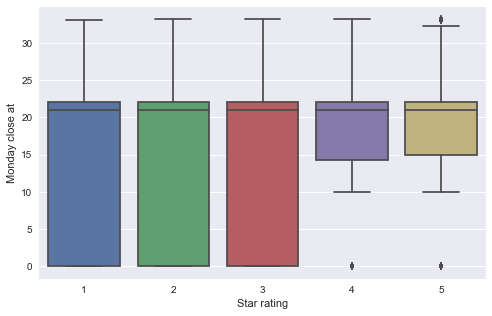

In [41]:
# Visualize closing time vs star rating
plt.figure(figsize=(8,5))
sns.boxplot(x='stars_x', y='Monday close at', data=restaurants)
plt.xlabel('Star rating')
plt.show()

I think there is a correlation between lateness of closing time and star rating. Restaurants that have more 4 or 5 star ratings close at later times.

Let's look at other days to find out.

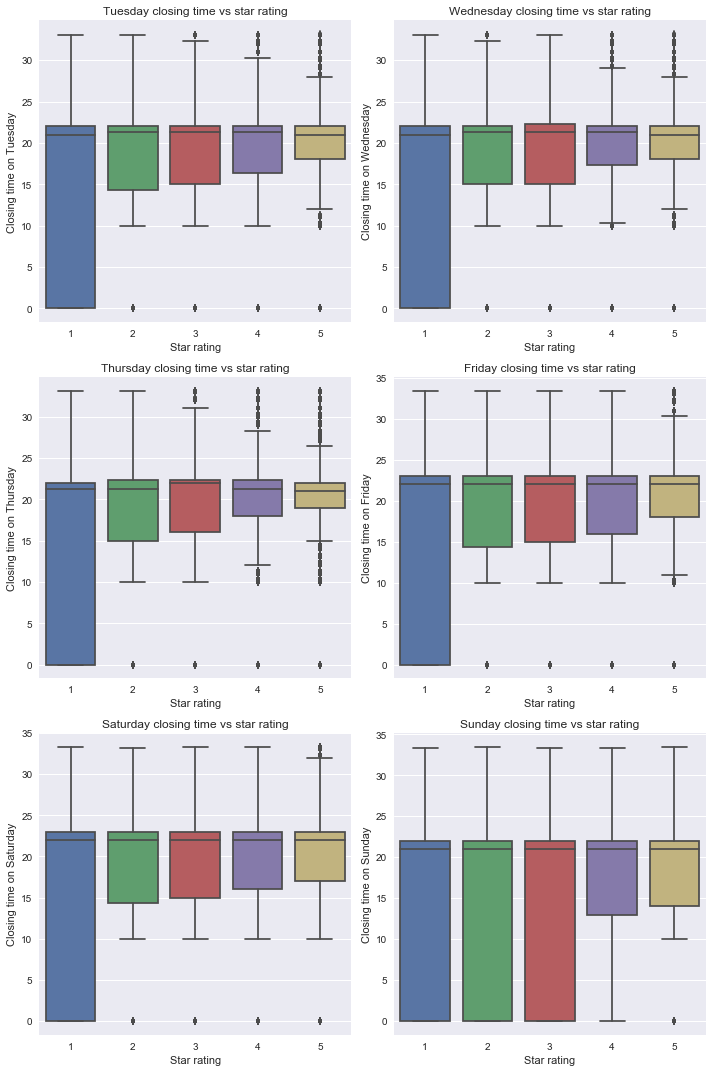

In [46]:
fig, axes=plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
for idx, day in enumerate(Weekdays[1:]):
    sns.boxplot(x='stars_x', y=day+' close at', data=restaurants, ax=axes.flat[idx])
    axes.flat[idx].set_xlabel('Star rating')
    axes.flat[idx].set_ylabel('Closing time on '+day)
    axes.flat[idx].set_title(day+' closing time vs star rating')
plt.tight_layout()
plt.show()

The trend is there. For 4 and 5 star ratings, the distribution is tighter around late times.

In [50]:
# 6-3-18 afternoon
restaurants.to_csv('yelp/restaurants_reviews_clean.csv')

<b>Now that we have finished our exploration of the data, we can decide what features to use when predicting star ratings besides the review text data. We will try three different models, logistic regression, svc, and randomforest.

We will keep the following columns as features: <br><br>
'Ambience casual', 'Ambience classy', 'Ambience divey', 'Ambience hipster', 'Ambience intimate', 'Ambience romantic', 'Ambience touristy', 'Ambience trendy', 'Ambience upscale', 'BikeParking', 'BusinessParking garage', 'BusinessParking lot', 'BusinessParking street', 'Caters', 'DogsAllowed', 'GoodForMeal dessert', 'GoodForMeal dinner', 'GoodForMeal latenight', 'NoiseLevel', 'RestaurantsAttire', 'RestaurantsPriceRange2', 'RestaurantsTableService', 'WiFi', 'year', 'Cuisine', 
'Monday close at', 'Tuesday close at', 'Wednesday close at', 'Thursday close at', 'Friday close at', 'Saturday close at', 'Sunday close at'<br><br>
Then we will perform dimensionality reduction on these features.

In [13]:
# Get a sample data frame containing a random sample of 1000 to save time for tuning the model
test_sample=restaurants[['stars_x', 'text']].sample(1000, axis=0)

In [15]:
test_sample.reset_index(inplace=True, drop=True)

In [16]:
test_sample.head(3)

,stars_x,text
0,2,I go here for the lunch and get the lunch spec...
1,4,This place is great. Had the meatloaf with mas...
2,4,So my Mom and I came in here to check this pla...


In [17]:
test_sample['stars_x'].value_counts()

5    3815
4    2784
3    1370
1    1107
2     924
Name: stars_x, dtype: int64

In [18]:
test_sample.to_csv('review_test.csv')

In [2]:
test_sample=pd.read_csv('review_test.csv', index_col=0)

In [3]:
stop_words=set(stopwords.words('english'))

In [8]:
X=test_sample['text'].values
y=test_sample['stars_x'].values

In [9]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, stratify=y)

In [37]:
min_dfs=[1, 5, 10, 20, 40, 60, 80, 100]

In [10]:
max_dfs=[0.6, 0.7, 0.8, 0.9, 1]

In [11]:
logreg=LogisticRegression(multi_class='multinomial', solver='newton-cg', C=1, class_weight='balanced')

In [12]:
scores=[]
for max_df in max_dfs:
    tfidf=TfidfVectorizer(stop_words='english', tokenizer=tfidf_tokenizer, sublinear_tf=True, min_df=1, 
                          ngram_range=(1,2), max_features=1000, max_df=max_df)
    X_train_tfidf=tfidf.fit_transform(X_train)
    X_test_tfidf=tfidf.transform(X_test)
    logreg.fit(X_train_tfidf, y_train)
    scores.append(logreg.score(X_test_tfidf, y_test))

In [13]:
scores

[0.5636, 0.5616, 0.564, 0.564, 0.3788]

In [14]:
Cs=[0.001, 0.01, 0.1, 1, 10, 100]

In [15]:
tfidf=TfidfVectorizer(stop_words='english', tokenizer=tfidf_tokenizer, sublinear_tf=True, min_df=1, 
                          ngram_range=(1,2), max_features=1000, max_df=0.8)

In [16]:
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)

In [17]:
scores=[]
for c in Cs:
    logreg=LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight='balanced', C=c)
    logreg.fit(X_train_tfidf, y_train)
    scores.append(logreg.score(X_test_tfidf, y_test))
print('Best score is: ', max(scores))
print('Best C value is: ', Cs[scores.index(max(scores))])

Best score is:  0.566
Best C value is:  0.1


In [52]:
# Use sentiment as another feature to help with the analysis
def get_sentiment(text):
    sentiment_scores=[]
    for review in text:
        text_blobed=TextBlob(review)
        sentiment_scores.append(text_blobed.sentiment.polarity)
    return(sentiment_scores)

In [53]:
sentiment_scores=get_sentiment(test_sample['text'])

In [55]:
sentiment_scores[0:10]

[0.21142857142857147,
 0.31607142857142856,
 0.3411458333333333,
 0.3078282828282828,
 0.2520833333333334,
 0.3061282051282051,
 0.19375,
 -0.05648148148148148,
 0.02442982456140352,
 0.1125]

In [56]:
test_sample['Sentiment']=sentiment_scores

In [58]:
X_new=test_sample[['text', 'Sentiment']].values
y_new=test_sample['stars_x'].values

In [59]:
X_new_train, X_new_test, y_new_train, y_new_test=train_test_split(X_new, y_new, test_size=0.25, stratify=y)

In [64]:
X_new_train_tfidf=tfidf.fit_transform(X_new_train[:, 0])
X_new_test_tfidf=tfidf.transform(X_new_test[:, 0])

In [71]:
type(X_new_train_tfidf)

scipy.sparse.csr.csr_matrix

In [65]:
X_new_train_tfidf.shape

(7500, 19463)

In [66]:
X_new_test_tfidf.shape

(2500, 19463)

In [77]:
X_new_train[:,1].shape

(7500,)

In [79]:
sentiment_train=X_new_train[:,1].reshape(-1,1)

In [89]:
sentiment_train=sentiment_train.astype(float)

In [90]:
sentiment_test=sentiment_test.astype(float)

In [91]:
sentiment_train.shape

(7500, 1)

In [83]:
sentiment_test.shape

(2500, 1)

In [92]:
X_new_train_tfidf_sentiment=scipy.sparse.hstack((X_new_train_tfidf, sentiment_train))
X_new_test_tfidf_sentiment=scipy.sparse.hstack((X_new_test_tfidf, sentiment_test))

In [13]:
logreg=LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight='balanced', C=0.1)

In [14]:
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [15]:
logreg.score(X_test_tfidf, y_test)

0.5584

In [18]:
param_grid={'C': Cs}

In [19]:
logreg_cv=GridSearchCV(logreg, param_grid)

In [20]:
logreg_cv.fit(X_train_tfidf, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
logreg_cv.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [22]:
logreg_cv.score(X_train_tfidf, y_train)

0.6889333333333333

In [23]:
logreg_cv.score(X_test_tfidf, y_test)

0.564

In [24]:
# Test LinearSVC model
lsvc=LinearSVC(class_weight='balanced')

In [25]:
lsvc.fit(X_train_tfidf, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [26]:
lsvc.score(X_test_tfidf, y_test)

0.5532

In [27]:
lsvc_cv=GridSearchCV(lsvc, param_grid)

In [28]:
lsvc_cv.fit(X_train_tfidf, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
df1 = {}
for i, score in enumerate(lsvc_cv.grid_scores_):
    df1[score[0][parameter]] = score[1]

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


KeyError: 'min_weight_fraction_leaf'

In [29]:
lsvc_cv.best_estimator_

LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [30]:
lsvc_cv.score(X_train_tfidf, y_train)

0.6826666666666666

In [31]:
lsvc_cv.score(X_test_tfidf, y_test)

0.5712

In [37]:
# Naive bayes
nbm=MultinomialNB()

In [40]:
alphas=[.1, 1, 5, 10, 50]

In [64]:
# Try random forest
# parameters and ranges to plot
param_grid = {"max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(2,150,1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

In [61]:
# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(dtc, param_grid = {parameter: num_range})
    grid_search.fit(X_train_tfidf, y_train)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_

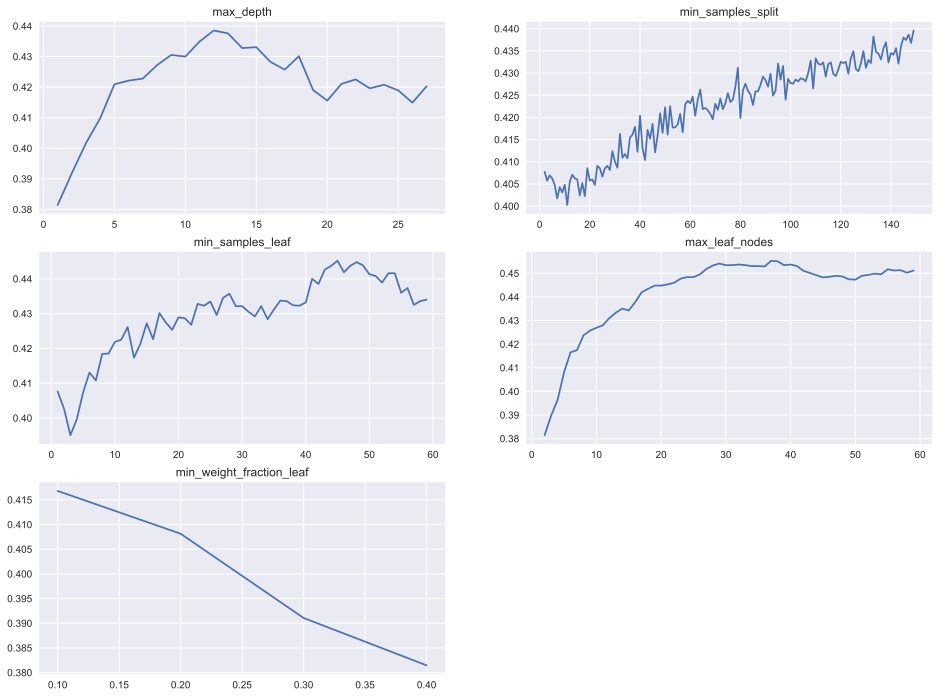

In [65]:
index = 1
plt.figure(figsize=(16,12))
parameters=[]
param_ranges=[]
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1
plt.show()

In [44]:
dtc=DTC()

In [45]:
dtc.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [46]:
dtc.score(X_train_tfidf, y_train)

1.0

In [47]:
dtc.score(X_test_tfidf, y_test)

0.4296

In [94]:
logreg.fit(X_new_train_tfidf_sentiment, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [95]:
logreg.score(X_new_test_tfidf_sentiment, y_test)

0.1944

In [100]:
lsvc=LinearSVC()

In [101]:
lsvc.fit(X_new_train_tfidf_sentiment, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [102]:
lsvc.score(X_new_test_tfidf_sentiment, y_test)

0.3064

In [103]:
X2=test_sample['Sentiment'].values
y2=test_sample['stars_x']

In [106]:
X2=X2.reshape(-1,1)
y2=y2.reshape(-1,1)

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [107]:
X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.25, stratify=y)

In [108]:
logreg.fit(X2_train, y2_train)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [109]:
logreg.score(X2_test, y2_test)

0.456

In [115]:
rfc=RFC(n_estimators=50)

In [111]:
tfidf_old=TfidfVectorizer(stop_words='english', sublinear_tf=True, min_df=1, max_df=0.6)

In [112]:
X_train_tfidf_old=tfidf_old.fit_transform(X_train)
X_test_tfidf_old=tfidf_old.transform(X_test)

In [116]:
rfc.fit(X_train_tfidf_old, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
rfc.score(X_test_tfidf_old, y_test)

0.526

In [35]:
confusion_matrix(pred, y_test)

array([[162,  59,  22,   8,  10],
       [ 45,  45,  43,  26,  10],
       [ 24,  53, 102,  77,  36],
       [ 28,  49, 110, 282, 241],
       [ 18,  25,  65, 303, 657]], dtype=int64)

In [7]:
test=word_tokenize(test)

In [8]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns=[word for (word, pos) in nltk.pos_tag(test) if is_noun(pos)]

In [9]:
nltk.pos_tag(test)

[('Love', 'VB'),
 ('the', 'DT'),
 ('staff', 'NN'),
 (',', ','),
 ('love', 'VBP'),
 ('the', 'DT'),
 ('meat', 'NN'),
 (',', ','),
 ('love', 'VB'),
 ('the', 'DT'),
 ('place', 'NN'),
 ('.', '.'),
 ('Prepare', 'NNP'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('long', 'JJ'),
 ('line', 'NN'),
 ('around', 'IN'),
 ('lunch', 'NN'),
 ('or', 'CC'),
 ('dinner', 'NN'),
 ('hours', 'NNS'),
 ('.', '.'),
 ('They', 'PRP'),
 ('ask', 'VBP'),
 ('you', 'PRP'),
 ('how', 'WRB'),
 ('you', 'PRP'),
 ('want', 'VBP'),
 ('you', 'PRP'),
 ('meat', 'NN'),
 (',', ','),
 ('lean', 'JJ'),
 ('or', 'CC'),
 ('something', 'NN'),
 ('maybe', 'RB'),
 (',', ','),
 ('I', 'PRP'),
 ('ca', 'MD'),
 ("n't", 'RB'),
 ('remember', 'VB'),
 ('.', '.'),
 ('Just', 'NNP'),
 ('say', 'VBP'),
 ('you', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('want', 'VB'),
 ('it', 'PRP'),
 ('too', 'RB'),
 ('fatty', 'RB'),
 ('.', '.'),
 ('Get', 'VB'),
 ('a', 'DT'),
 ('half', 'JJ'),
 ('sour', 'JJ'),
 ('pickle', 'NN'),
 ('and', 'CC'),
 ('a', 'DT'),
 ('hot', 'JJ'),
 ('pepper',

In [10]:
nouns

['staff',
 'meat',
 'place',
 'Prepare',
 'line',
 'lunch',
 'dinner',
 'hours',
 'meat',
 'something',
 'Just',
 'pickle',
 'pepper',
 'Hand',
 'fries']

In [26]:
nltk.pos_tag(test)[0][1]

str

In [11]:
is_adjective=lambda pos: pos[:2]=='JJ'
adjectives=[word for (word, pos) in nltk.pos_tag(test) if is_adjective(pos)]

In [12]:
adjectives

['long', 'lean', 'half', 'sour', 'hot', 'french']

In [ ]:
text_tokens=[word_tokenize(x) for x in text]

<strong> Try machine learning on the restaurant data to predict star ratings. </strong>

In [3]:
# Take 50000 samples to test algorithms
restaurants_sample=restaurants.sample(50000, axis=0)

In [4]:
restaurants_sample['stars_x'].value_counts()

5    19199
4    13495
3     6841
1     5555
2     4910
Name: stars_x, dtype: int64

In [5]:
text=restaurants_sample['text'].tolist()

In [7]:
text_tokens=[word_tokenize(x) for x in text]

In [9]:
is_adjective=lambda pos: pos[:2]=='JJ'

In [10]:
text_adjectives=[[word for (word, pos) in nltk.pos_tag(text) if is_adjective(pos)] for text in text_tokens]

In [17]:
text_adjectives[2]

['jumbled',
 'daily',
 'culinary',
 'dry',
 'real',
 'more',
 'sure',
 'same',
 'delicious',
 'past']

In [16]:
nltk.pos_tag(text_tokens[1])

[('Small', 'NN'),
 (',', ','),
 ('overcrowded', 'VBN'),
 (',', ','),
 ('unfriendly', 'JJ'),
 ('staff', 'NN'),
 ('.', '.'),
 ('The', 'DT'),
 ('food', 'NN'),
 ('is', 'VBZ'),
 ('okay', 'JJ'),
 ('-', ':'),
 ('typical', 'JJ'),
 ('Italian', 'JJ'),
 ('fair', 'NN'),
 ('that', 'WDT'),
 ('could', 'MD'),
 ('be', 'VB'),
 ('better', 'RB'),
 ('seasoned', 'VBN'),
 ('.', '.'),
 ('There', 'EX'),
 ('are', 'VBP'),
 ('much', 'RB'),
 ('better', 'JJR'),
 ('options', 'NNS'),
 ('nearby', 'RB'),
 (',', ','),
 ('but', 'CC'),
 ('in', 'IN'),
 ('a', 'DT'),
 ('pinch', 'NN'),
 (',', ','),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('decent', 'JJ'),
 ('.', '.')]

In [18]:
text_adjectives_col=[' '.join(x) for x in text_adjectives]

In [19]:
text_adjectives_col[0]

'best traditional traditional little much'

In [20]:
restaurants_sample['text_new']=text_adjectives_col

In [22]:
restaurants_sample.head(3)

,cool,date,funny,review_id,stars_x,text,useful,user_id,categories,name,review_count,state,text_new
3124336,0,2017-02-13,0.0,gDQpF8K_e_p4znArguOjlQ,3,Homemade spicy vodka in a Bloody Mary was the ...,0.0,LDdumyg2xaFO_o6nqgtkAw,"['Food', 'Cocktail Bars', 'American (New)', 'N...",HEXX kitchen + bar,1313,NV,best traditional traditional little much
689921,0,2012-01-15,2.0,thctMgpedjXgo-0IF8DBWQ,2,"Small, overcrowded, unfriendly staff.\r\r\n\r\...",2.0,vgjIDXVuy6SLuQxKRjlHQw,"['Salad', 'American (New)', 'Event Planning & ...",Legends Eatery,126,PA,unfriendly okay typical Italian better decent
2504222,0,2012-08-04,0.0,MRf0NlOjIoOIBX2T949qxA,4,It's been some time since I first set foot int...,1.0,WN-4DUGD6k0OI6KfoJMhhg,"['Turkish', 'Middle Eastern', 'Restaurants']",Istanbul Grille,48,PA,jumbled daily culinary dry real more sure same...


In [75]:
X=restaurants_sample['text'].values
y=restaurants_sample['stars_x'].values

In [76]:
min_dfs=[1, 5, 10, 20, 40, 60, 80, 100]

In [79]:
#CountVec=CountVectorizer(stop_words='english', token_pattern=r"(?u)\b\w\w+\b|!")
scores=[]
for min_df in min_dfs:
    tfidf_vec=TfidfVectorizer(stop_words='english', sublinear_tf=True, min_df=min_df)
    X1=tfidf_vec.fit_transform(X)
    X_train, X_test, y_train, y_test=train_test_split(X1, y, test_size=0.25, stratify=y)
    clf_mb.fit(X_train, y_train)
    scores.append(clf_mb.score(X_test, y_test))
print(scores)

[0.51608, 0.53208, 0.53624, 0.55336, 0.5572, 0.55496, 0.55392, 0.5524]


In [60]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, stratify=y)

In [61]:
X_train_trans=CountVec.fit_transform(X_train)
X_test_trans=CountVec.transform(X_test)

In [62]:
X_train_trans.shape

(37500, 396)

In [63]:
X_test_trans.shape

(12500, 396)

In [29]:
#tfidf_vec=TfidfVectorizer(stop_words='english', token_pattern=r"(?u)\b\w\w+\b|!", sublinear_tf=True, ngram_range=(1,2))
#tfidf_vec=TfidfVectorizer(stop_words='english', sublinear_tf=True, ngram_range=(1,2))
tfidf_vec=TfidfVectorizer(stop_words='english', sublinear_tf=True)

In [30]:
X_tfidf=tfidf_vec.fit_transform(X)

In [31]:
X_tfidf.shape

(50000, 14282)

In [32]:
y.shape

(50000,)

In [34]:
N=3
for i in range(1,6):
    features_chi2=chi2(X_tfidf, y==i)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(str(i)+' Stars'))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '1 Stars':
  . Most correlated unigrams:
. terrible
. worst
. horrible
  . Most correlated bigrams:
. 
# '2 Stars':
  . Most correlated unigrams:
. disappointing
. delicious
. ok
  . Most correlated bigrams:
. 
# '3 Stars':
  . Most correlated unigrams:
. decent
. average
. ok
  . Most correlated bigrams:
. 
# '4 Stars':
  . Most correlated unigrams:
. tasty
. horrible
. good
  . Most correlated bigrams:
. 
# '5 Stars':
  . Most correlated unigrams:
. delicious
. best
. amazing
  . Most correlated bigrams:
. 


In [40]:
X_train, X_test, y_train, y_test=train_test_split(X_tfidf, y, test_size=0.25, stratify=y)

In [71]:
clf_mb=MultinomialNB(alpha=0.01)

In [72]:
clf_mb.fit(X_train_trans, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [73]:
clf_mb.score(X_train_trans, y_train)

0.5364533333333333

In [74]:
clf_mb.score(X_test_trans, y_test)

0.5108

In [44]:
logreg=LogisticRegression(multi_class='multinomial', solver='newton-cg', C=0.01, class_weight='balanced')

In [45]:
logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [46]:
logreg.score(X_train, y_train)

0.48928

In [47]:
logreg.score(X_test, y_test)

0.47504

In [19]:
logreg=LogisticRegression(multi_class='multinomial', class_weight='balanced')

In [20]:
params_grid={'C':[0.001,0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}

In [21]:
logreg_cv=GridSearchCV(logreg, params_grid)

In [22]:
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
logreg_cv.best_estimator_

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [24]:
logreg_cv.score(X_train, y_train)

0.9989333333333333

In [25]:
logreg_cv.score(X_test, y_test)

0.59704

In [26]:
logreg_cv_pred=logreg_cv.predict(X_test)

In [27]:
confusion_matrix(y_test, logreg_cv_pred, labels=[1,2,3,4,5])

array([[1007,  216,   78,   33,   51],
       [ 330,  394,  308,   99,   56],
       [ 128,  236,  670,  539,  170],
       [  52,   59,  343, 1714, 1247],
       [  26,   29,   83,  954, 3678]], dtype=int64)

In [110]:
print(classification_report(y_test, logreg_cv_pred, target_names=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']))

             precision    recall  f1-score   support

     1 Star       0.65      0.72      0.69      1399
    2 Stars       0.43      0.33      0.37      1211
    3 Stars       0.43      0.37      0.40      1736
    4 Stars       0.50      0.49      0.50      3376
    5 Stars       0.71      0.77      0.74      4778

avg / total       0.58      0.59      0.58     12500



In [53]:
# Save the tuned model
joblib.dump(logreg_cv, 'yelp_logreg_cv_2_25_18.pkl')

['yelp_logreg_cv_2_25_18.pkl']

In [54]:
gbc=GBC()

In [ ]:
gbc.fit(X_train, y_train)

In [28]:
# Try group 1 star as bad, 2, 3, and 4 stars as ok, and 5 stars as good and redo the logistic regression
def rating_group(star):
    if star==1:
        star=0
    elif star in [2,3,4]:
        star=1
    elif star==5:
        star=2
    return(star)
restaurants['rating_group']=restaurants['stars_x'].apply(rating_group)

In [29]:
restaurants.head(3)

,cool,date,funny,review_id,stars_x,text,useful,user_id,categories,name,review_count,state,rating_group
0,0,2016-05-28,0.0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0.0,bv2nCi5Qv5vroFiqKGopiw,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Schwartz's,1953,QC,good
1,0,2016-05-28,0.0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0.0,bv2nCi5Qv5vroFiqKGopiw,"['Diners', 'Food', 'Restaurants', 'Delis']",Wilensky's,84,QC,good
2,0,2016-05-28,0.0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0.0,bv2nCi5Qv5vroFiqKGopiw,"['Restaurants', 'Canadian (New)', 'Italian']",Tuck Shop,50,QC,good


In [30]:
LE=LabelEncoder()

In [31]:
rating_group=LE.fit_transform(restaurants['rating_group'])

In [32]:
restaurants['rating_group']=rating_group

In [33]:
restaurants.head(3)

,cool,date,funny,review_id,stars_x,text,useful,user_id,categories,name,review_count,state,rating_group
0,0,2016-05-28,0.0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0.0,bv2nCi5Qv5vroFiqKGopiw,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Schwartz's,1953,QC,1
1,0,2016-05-28,0.0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0.0,bv2nCi5Qv5vroFiqKGopiw,"['Diners', 'Food', 'Restaurants', 'Delis']",Wilensky's,84,QC,1
2,0,2016-05-28,0.0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0.0,bv2nCi5Qv5vroFiqKGopiw,"['Restaurants', 'Canadian (New)', 'Italian']",Tuck Shop,50,QC,1


In [35]:
restaurants[['stars_x', 'rating_group']].drop_duplicates()

,stars_x,rating_group
0,5,1
4,4,2
8,3,2
16,1,0
23,2,2


In [44]:
Lsvc=LinearSVC(class_weight='balanced')

In [36]:
reviews_group_sample=restaurants.sample(50000, axis=0)

In [37]:
reviews_group_sample['rating_group'].value_counts()

2    25107
1    19201
0     5692
Name: rating_group, dtype: int64

In [39]:
X_new=reviews_group_sample['text'].values
y_new=reviews_group_sample['rating_group'].values

In [41]:
X_new_tfidf=tfidf_vec.fit_transform(X_new)

In [42]:
X_train_new, X_test_new, y_train_new, y_test_new=train_test_split(X_new_tfidf, y_new, test_size=0.25, stratify=y)

In [45]:
Lsvc.fit(X_train_new, y_train_new)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [46]:
Lsvc.score(X_train_new, y_train_new)

0.9991733333333334

In [47]:
Lsvc.score(X_test_new, y_test_new)

0.73904

In [48]:
Lsvc_pred=Lsvc.predict(X_test_new)

In [49]:
confusion_matrix(y_test_new, Lsvc_pred, labels=[0,1,2])

array([[ 870,   33,  422],
       [  25, 3629, 1237],
       [ 298, 1247, 4739]], dtype=int64)

In [51]:
print(classification_report(y_test_new, Lsvc_pred, target_names=['bad', 'ok', 'good']))

             precision    recall  f1-score   support

        bad       0.73      0.66      0.69      1325
         ok       0.74      0.74      0.74      4891
       good       0.74      0.75      0.75      6284

avg / total       0.74      0.74      0.74     12500



In [92]:
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [93]:
Lsvc_cv=GridSearchCV(Lsvc, param_grid)

In [94]:
Lsvc_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [96]:
Lsvc_cv.best_estimator_

LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [95]:
Lsvc_cv.score(X_train, y_train)

0.8924533333333333

In [97]:
Lsvc_cv.score(X_test, y_test)

0.5944

In [98]:
Lsvc_pred=Lsvc_cv.predict(X_test)

In [99]:
confusion_matrix(y_test, Lsvc_pred, labels=[1,2,3,4,5])

array([[1102,  182,   53,   16,   46],
       [ 438,  396,  262,   67,   48],
       [ 165,  261,  619,  477,  214],
       [ 105,   67,  390, 1393, 1421],
       [  83,   27,   98,  650, 3920]], dtype=int64)

In [87]:
rfc=RFC()

In [88]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [89]:
rfc.score(X_train, y_train)

0.9921866666666667

In [90]:
rfc.score(X_test, y_test)

0.47096

In [132]:
X_train_svd, X_test_svd, y_train_svd, y_test_svd=train_test_split(X_svd, y, test_size=0.25, stratify=y)

In [134]:
Lsvc_cv.fit(X_train_svd, y_train_svd)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [135]:
Lsvc_cv.score(X_train_svd, y_train_svd)

0.5693333333333334

In [136]:
Lsvc_cv.score(X_test_svd, y_test_svd)

0.56024

In [137]:
logreg_cv.fit(X_train_svd, y_train_svd)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [138]:
logreg_cv.score(X_train_svd, y_train_svd)

0.5592

In [139]:
logreg_cv.score(X_test_svd, y_test_svd)

0.55792